In [1]:
### Import libraries

import igraph as ig
import numpy as np
import os
from collections import Counter, OrderedDict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from auxiliar_bb import apply_backboning
from auxiliar_projections_large import apply_projection
import statistics
from sklearn.manifold import TSNE
import itertools 
# Asegúrate de que esta línea esté al inicio de tu script o notebook.
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

In [2]:
# Asegúrate de que esta es la versión corregida con .get() para evitar KeyErrors

def evaluate_solution(bip, proj, typen, metric_pair):
    """Dado bip y proj metrics, arma x, f, g. Usa solo las tres métricas en metric_pair."""
    
    def get_metric(d, key):
        return d.get(key, 0) 

    # Lista completa de las 6 posibles FOs
    all_f_values = [
        # FO1: Nodos (0)
        abs(get_metric(bip, "x1") - get_metric(proj, "x4")) if typen==0 else abs(get_metric(bip, "x2") - get_metric(proj, "x4")),
        # FO2: Densidad (1)
        abs(((2*get_metric(proj, "x5")) / (get_metric(proj, "x4")*(get_metric(proj, "x4")-1))) - get_metric(bip, "x15")), 
        # FO3: CC (2)
        abs(get_metric(proj, "x8") - get_metric(bip, "x7")),  
        # FO4: Power Law (3)
        abs(get_metric(proj, "x11") - get_metric(proj, "x12")), 
        # FO5: APL (4)
        abs(get_metric(proj, "x9") - get_metric(bip, "x10")), 
        # FO6: Grado Promedio (5)
        abs(get_metric(proj, "x13") - get_metric(bip, "x16"))  
    ]
    
    # Selecciona solo las TRES FOs especificadas en metric_pair (e.g., (0, 1, 2))
    f = np.array([
        all_f_values[metric_pair[0]],
        all_f_values[metric_pair[1]],
        all_f_values[metric_pair[2]] # <--- TERCER OBJETIVO AÑADIDO
    ])
    
    # Restricciones g_i(x)<=0 (sin cambios)
    x = {**bip, **proj}
    g = np.array([
        (get_metric(bip, "x1")/2) - (get_metric(proj, "x4")) if typen==0 else (get_metric(bip, "x2")/2) - (get_metric(proj, "x4")), 
        (get_metric(bip, "x1")-1) - get_metric(proj, "x5") if typen==0 else (get_metric(bip, "x2")-1) - get_metric(proj, "x5") 
    ])
    
    return dict(metrics=x, f=f, g=g, graph=proj)
    
# Las funciones is_feasible, pareto_front, crowding_distance, y pareto_rank_all NO CAMBIAN.

def is_feasible(sol):
    return np.all(sol["g"] <= 0)

def pareto_front(sols):
    front = []
    for i, si in enumerate(sols):
        if any(np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"])
               for j, sj in enumerate(sols) if i!=j):
            continue
        front.append(si)
    return front

def crowding_distance(front):
    N, k = len(front), front[0]["f"].size
    F = np.array([s["f"] for s in front])
    dist = np.zeros(N)
    for m in range(k):
        idx = np.argsort(F[:,m])
        f_min, f_max = F[idx[0],m], F[idx[-1],m]
        dist[idx[0]] = dist[idx[-1]] = np.inf
        if f_max == f_min: continue
        for i in range(1, N-1):
            dist[idx[i]] += (F[idx[i+1],m] - F[idx[i-1],m]) / (f_max - f_min)
    return dist

def pareto_rank_all(solutions):
    """
    Clasifica todas las soluciones en frentes de Pareto.
    Devuelve una lista de listas: cada sublista contiene un frente.
    """
    remaining = solutions.copy()
    fronts = []
    
    while remaining:
        current_front = []
        for i, si in enumerate(remaining):
            dominated = False
            for j, sj in enumerate(remaining):
                if i == j:
                    continue
                if np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"]):
                    dominated = True
                    break
            if not dominated:
                current_front.append(si)
        
        fronts.append(current_front)
        remaining = [s for s in remaining if all(s is not r for r in current_front)]
    
    return fronts



In [3]:
### Select dataset
DATASET = "amz" # ["amz", "um", "am"]
PROJ_NAMES = ["simple", "vector", "jaccard", "neighs", "hyper", "resall"]

nombre_proyecciones = {
    "simple": "Weighted", "jaccard": "Jaccard", "hyper": "Hyperbolic",
    "vector": "Vectorized", "resall": "Resource\nAllocation", "neighs": "Neighborhood"
}
nombre_backbonings = { "NC": "Noise Corrected", "DF": "Disparity Filter"}
COLORS_PR = ["#ef476fff", "#f78c6bff", "#ffd166ff", "#06d6a0ff", "#118ab2ff", "#718355"]
COLORS_BB = [ "#8ab17d", "#e9c46a"]
COLORS_SV = ["#718355", "#87986a", "#97a97c", "#b5c99a"]

if DATASET == "um":
    FILENAME = "../12-third_year/00-Data/08-imdb/user-movie.graphml"
elif DATASET == "am":
    FILENAME = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/actor-movie.graphml"
elif DATASET == "amz":
    FILENAME = "binet-AMZ-Rw.graphml"


### Load Dataset

In [4]:
g = ig.read(FILENAME)
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()


IGRAPH U-WT 17079 32769 -- 
+ attr: freq (v), id (v), type (v), weight (e)

|U|= 9561  	|R|= 7518  	|U|+|R|= 17079 = 17079

The graph IS bipartite


In [5]:
NODETYPE = 0   # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
#bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics = {'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426, 'x15': gb.density(), 'x16': statistics.mean(gb.degree(gb.vs.select(type=0)))}

bip_metrics

{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426,
 'x15': 0.00022469516962160804,
 'x16': 3.427361154690932}

In [15]:
# ---------------------------------------------------------------------------------
# FUNCIÓN PARA PLOTEAR EN 3D (Eje F2 hacia arriba)
# ---------------------------------------------------------------------------------

def plot_pareto_front_3d(final_DF, all_fronts, xlabel_name, ylabel_name, zlabel_name, plot_title):
    
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import pandas as pd
    import numpy as np 
    import matplotlib.cm as cm 

    # --- 1. PREPARACIÓN DE DATOS Y MAPPING (Igual) ---

    rank_map = {}
    for rank, front in enumerate(all_fronts, 1):
        for sol in front:
            rank_map[sol["filename"]] = rank 

    final_DF['rank'] = final_DF['name'].map(rank_map).fillna(0).astype(int) 
    plot_DF = final_DF[final_DF['rank'] > 0].copy()

    split_names = plot_DF['name'].str.split('_', expand=True)

    plot_DF['Proyeccion'] = split_names[2]
    plot_DF['Backbone'] = split_names[3]
    plot_DF['Alpha'] = split_names[4] 
    
    # --- 2. MAPEO DE ESTILOS VISUALES (Igual) ---
    
    plot_DF['rank_str'] = plot_DF['rank'].astype(str)
    plot_DF['ID'] = 'S' + (plot_DF.reset_index().index + 1).astype(str)
    plot_DF['legend_label'] = plot_DF.apply(
        lambda row: f"F{row['rank_str']} | {row['ID']}: {row['name'].split('_')[0]}_{row['name'].split('_')[1]}", 
        axis=1
    )

    unique_projections = sorted(plot_DF['Proyeccion'].unique())
    marker_list_3d = ['o', '^', 's', 'D', 'p', 'h', 'v', '>', '<'] 
    PROJ_MARKERS = dict(zip(unique_projections, marker_list_3d[:len(unique_projections)]))

    unique_backbones = sorted(plot_DF['Backbone'].unique())
    BB_FILLED_STATUS = dict(zip(unique_backbones, [True, False])) 
    plot_DF['is_filled'] = plot_DF['Backbone'].map(BB_FILLED_STATUS)

    unique_alphas = sorted(plot_DF['Alpha'].unique())
    if len(unique_alphas) >= 4:
        ALPHA_SIZES = {
            unique_alphas[0]: 60, unique_alphas[1]: 60,
            unique_alphas[2]: 150, unique_alphas[3]: 150
        }
    else:
        ALPHA_SIZES = {alpha: 100 for alpha in unique_alphas}
        
    plot_DF['size'] = plot_DF['Alpha'].map(ALPHA_SIZES)

    LINEWIDTH_BASE = 0.5   
    LINEWIDTH_INCREASED = 2.0
    
    # --- 3. COMIENZA LA GRÁFICA 3D ---

    fig = plt.figure(figsize=(16, 10)) 
    ax = fig.add_subplot(111, projection='3d')

    unique_ranks = sorted(plot_DF['rank'].unique())
    num_unique_ranks = len(unique_ranks)
    cmap = cm.get_cmap('tab10' if num_unique_ranks <= 10 else 'tab20', num_unique_ranks) 

    legend_data = {}
    marker_handles = {}
    fill_handles = {}
    size_handles = {} 

    # 3a. Graficar los puntos
    for index, row in plot_DF.iterrows():
        
        rank_int = row['rank']
        color = cmap(rank_int - 1)
        
        # Configuración de relleno y borde
        if row['is_filled']:
            facecolor = color 
            edgecolor_val = color 
            linewidth_val = LINEWIDTH_BASE 
        else:
            facecolor = 'none' 
            edgecolor_val = color 
            linewidth_val = LINEWIDTH_INCREASED 
        
        # CAMBIO CLAVE: Intercambiamos f2 y f3 en el scatter.
        # Matplotlib Axes: X (f1), Y (f3), Z (f2 - ARRIBA)
        ax.scatter(
            row['f1'],
            row['f3'],  # Ahora f3 va al eje Y de Matplotlib (profundidad)
            row['f2'],  # Ahora f2 va al eje Z de Matplotlib (altura)
            s=row['size'],             
            alpha=0.8,
            edgecolor=edgecolor_val,
            linewidth=linewidth_val,
            marker=PROJ_MARKERS[row['Proyeccion']], 
            color=color,           
            facecolor=facecolor 
        )
        
        # Recolección de handles (Adaptados al nuevo orden de ejes)
        legend_data[row['ID']] = {'color': color, 'label': row['legend_label']}
        
        marker_handles[row['Proyeccion']] = ax.scatter([], [], [], marker=PROJ_MARKERS[row['Proyeccion']], color='gray', s=100, label=row['Proyeccion'], facecolor='gray', edgecolor='black', linewidth=LINEWIDTH_BASE)
        
        if row['is_filled'] and row['Backbone'] not in fill_handles:
            fill_handles[row['Backbone']] = ax.scatter([], [], [], marker='o', color='gray', s=100, facecolor='gray', edgecolor='black', label=f'{row["Backbone"]} (Rellenado)', linewidth=LINEWIDTH_BASE)
        elif not row['is_filled'] and row['Backbone'] not in fill_handles: 
            fill_handles[row['Backbone']] = ax.scatter([], [], [], marker='o', color='gray', s=100, facecolor='none', edgecolor='black', label=f'{row["Backbone"]} (No Rellenado)', linewidth=LINEWIDTH_INCREASED)
            
        if row['size'] == 60 and 'Small' not in size_handles:
            size_handles['Small'] = ax.scatter([], [], [], marker='o', color='gray', s=60, edgecolor='black', facecolor='gray', label=f'Alpha bajo ({unique_alphas[0]}/{unique_alphas[1]})', linewidth=LINEWIDTH_BASE)
        elif row['size'] == 150 and 'Large' not in size_handles:
            size_handles['Large'] = ax.scatter([], [], [], marker='o', color='gray', s=150, edgecolor='black', facecolor='gray', label=f'Alpha alto ({unique_alphas[2]}/{unique_alphas[3]})', linewidth=LINEWIDTH_BASE)


    # 3b. Leyendas (Igual)

    all_handles = []
    all_handles.extend(marker_handles.values())
    all_handles.extend(fill_handles.values())
    all_handles.extend(size_handles.values()) 

    legend_aux = ax.legend(handles=all_handles, 
                        title="Variables de Configuración:", 
                        loc='lower left', 
                        bbox_to_anchor=(1.05, 1.01),
                        fontsize=8)
    
    fig.add_artist(legend_aux)

    legend_handles_main = []
    sorted_ids = plot_DF.sort_values(by=['rank', 'ID'])['ID'].tolist()

    for id_key in sorted_ids:
        data = legend_data[id_key]
        proxy = ax.scatter([], [], [], c=[data['color']], label=data['label'], s=100, edgecolor=data['color'], facecolor=data['color'], linewidth=LINEWIDTH_BASE) 
        legend_handles_main.append(proxy)


    legend_main = ax.legend(handles=legend_handles_main, 
              title="Frente | ID: Nombre del Grafo", 
              loc='upper left', 
              bbox_to_anchor=(1.05, 1), 
              fontsize=8)

    fig.add_artist(legend_main)


    # 3c. Finalizar el Gráfico
    ax.set_title(plot_title, fontsize=16)
    
    # ETIQUETAS: Tienen que seguir el orden de los datos originales
    ax.set_xlabel(f'$f_1$ ({xlabel_name})', fontsize=14)    # Mapeado a X
    ax.set_ylabel(f'$f_3$ ({zlabel_name})', fontsize=14)    # Mapeado a Y (Profundidad)
    ax.set_zlabel(f'$f_2$ ({ylabel_name})', fontsize=14)    # Mapeado a Z (Altura)


    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')

    # CAMBIA ESTOS VALORES PARA OBTENER LA PERSPECTIVA DESEADA
    ax.view_init(elev=30., azim=-45) # Prueba con diferentes elev y azim
    
    plt.subplots_adjust(right=0.7) 

    plt.show()


--- EVALUANDO 3D: FO1 (Nodos) vs FO2 (Densidad) vs FO3 (CC) ---
Soluciones factibles encontradas: 40


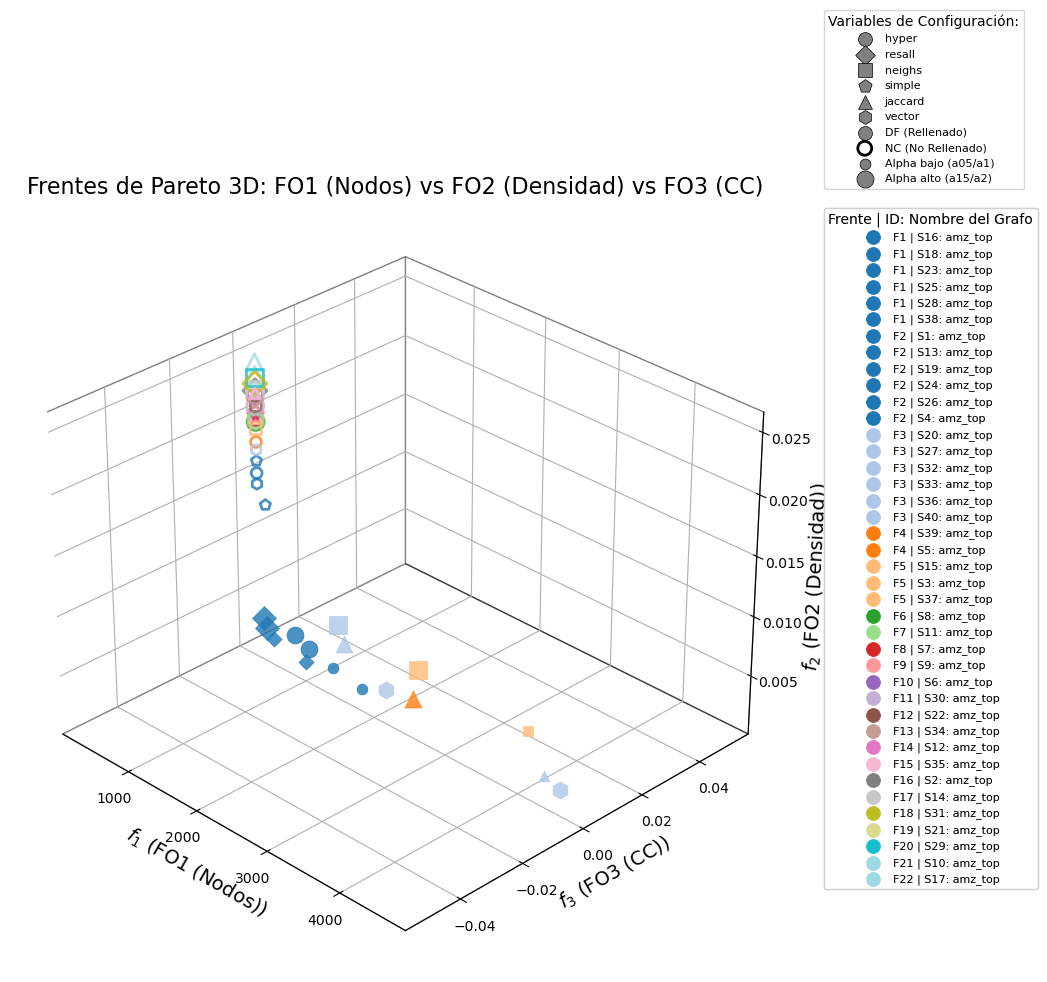


--- EVALUANDO 3D: FO1 (Nodos) vs FO2 (Densidad) vs FO4 (Power Law) ---
Soluciones factibles encontradas: 40


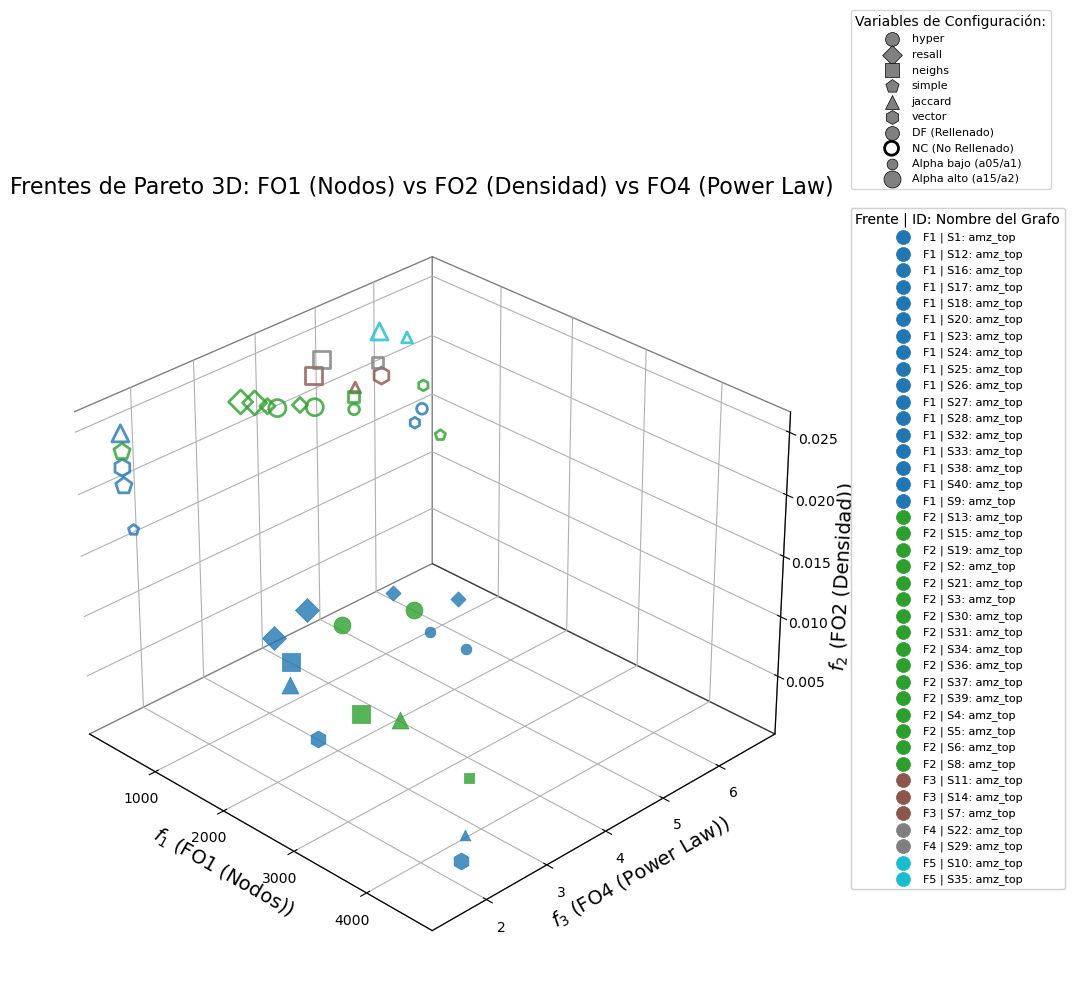


--- EVALUANDO 3D: FO1 (Nodos) vs FO2 (Densidad) vs FO5 (APL) ---
Soluciones factibles encontradas: 40


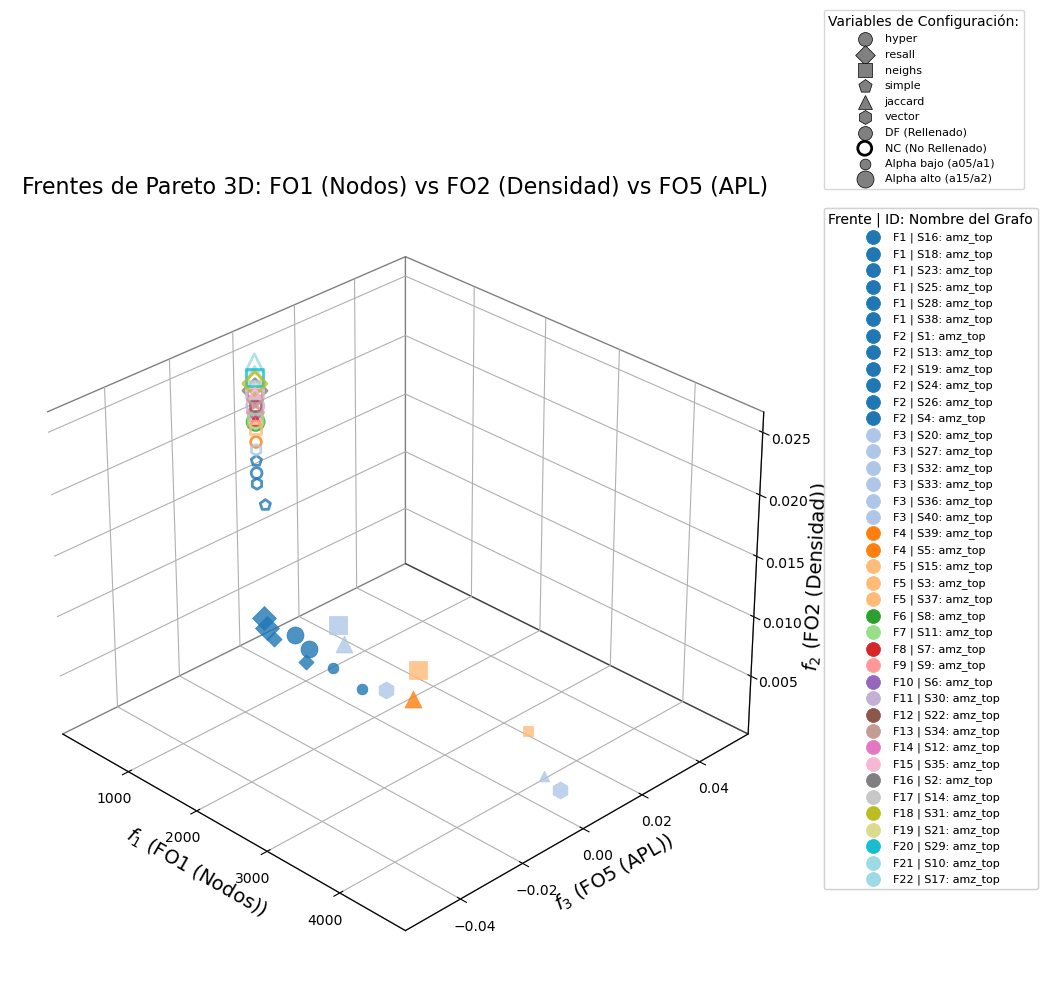


--- EVALUANDO 3D: FO1 (Nodos) vs FO2 (Densidad) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 40


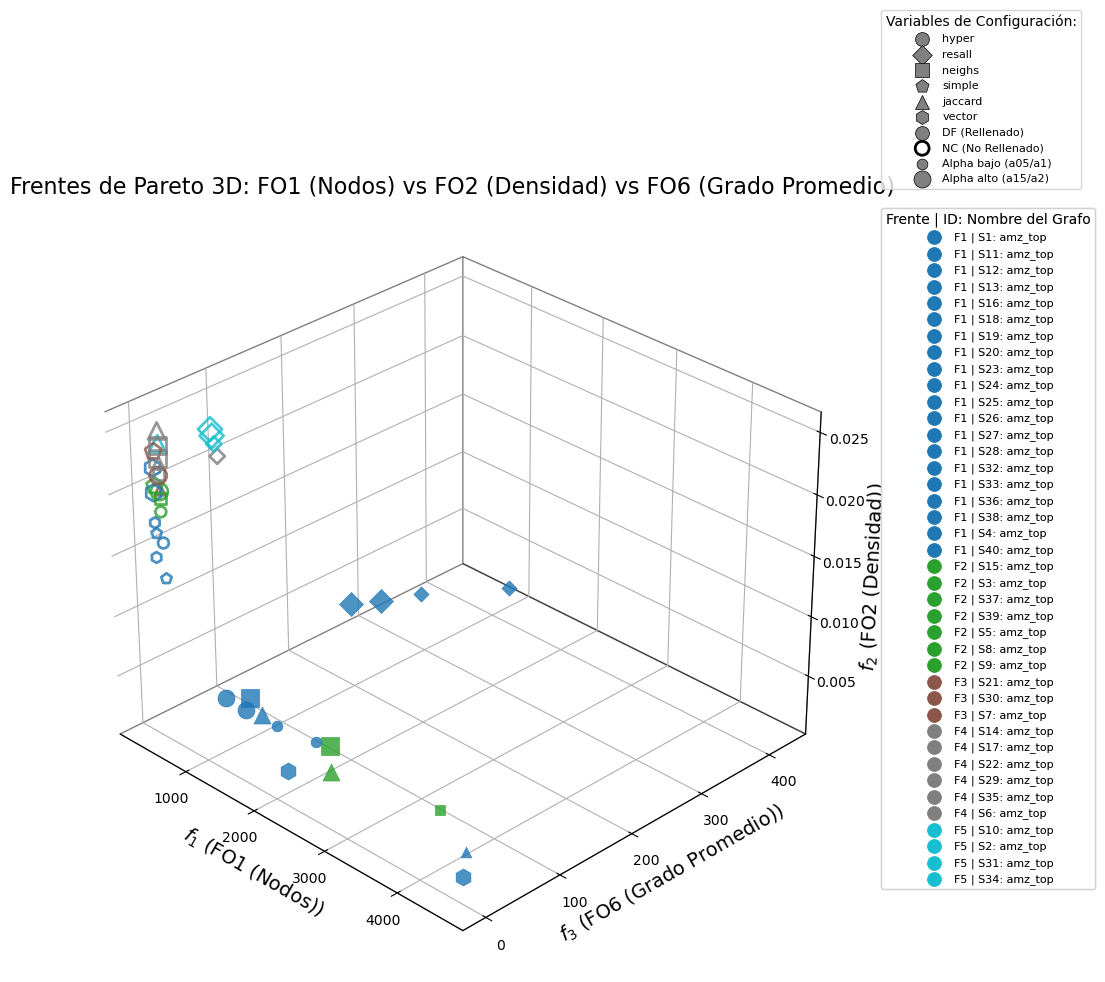


--- EVALUANDO 3D: FO1 (Nodos) vs FO3 (CC) vs FO4 (Power Law) ---
Soluciones factibles encontradas: 40


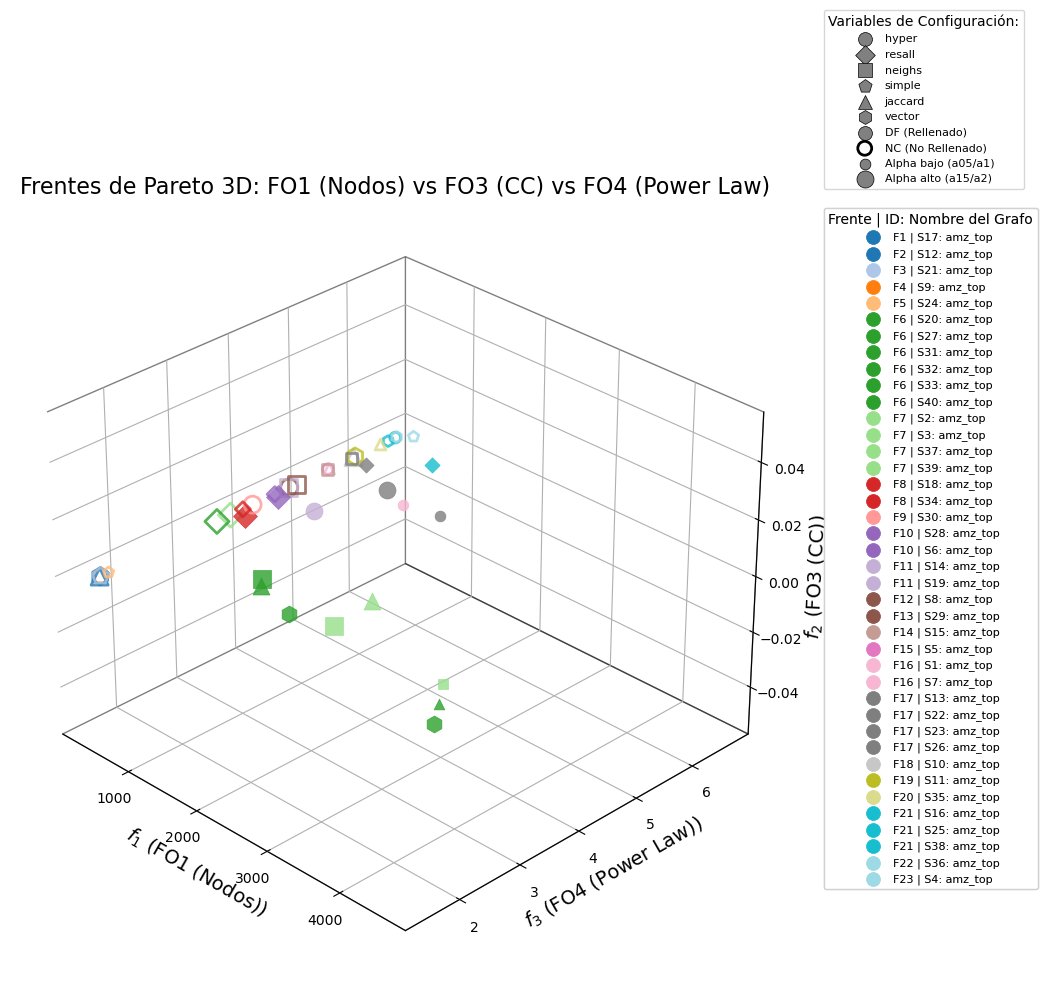


--- EVALUANDO 3D: FO1 (Nodos) vs FO3 (CC) vs FO5 (APL) ---
Soluciones factibles encontradas: 40


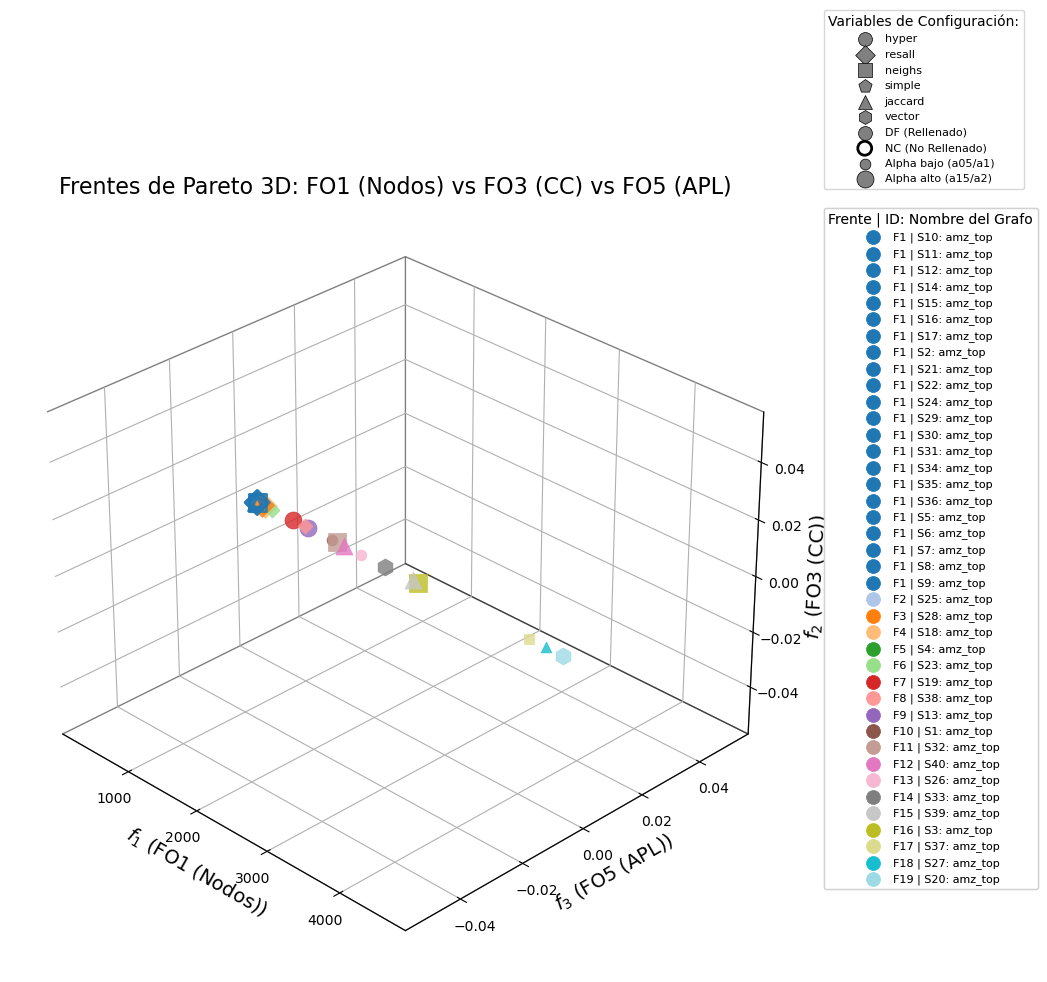


--- EVALUANDO 3D: FO1 (Nodos) vs FO3 (CC) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 40


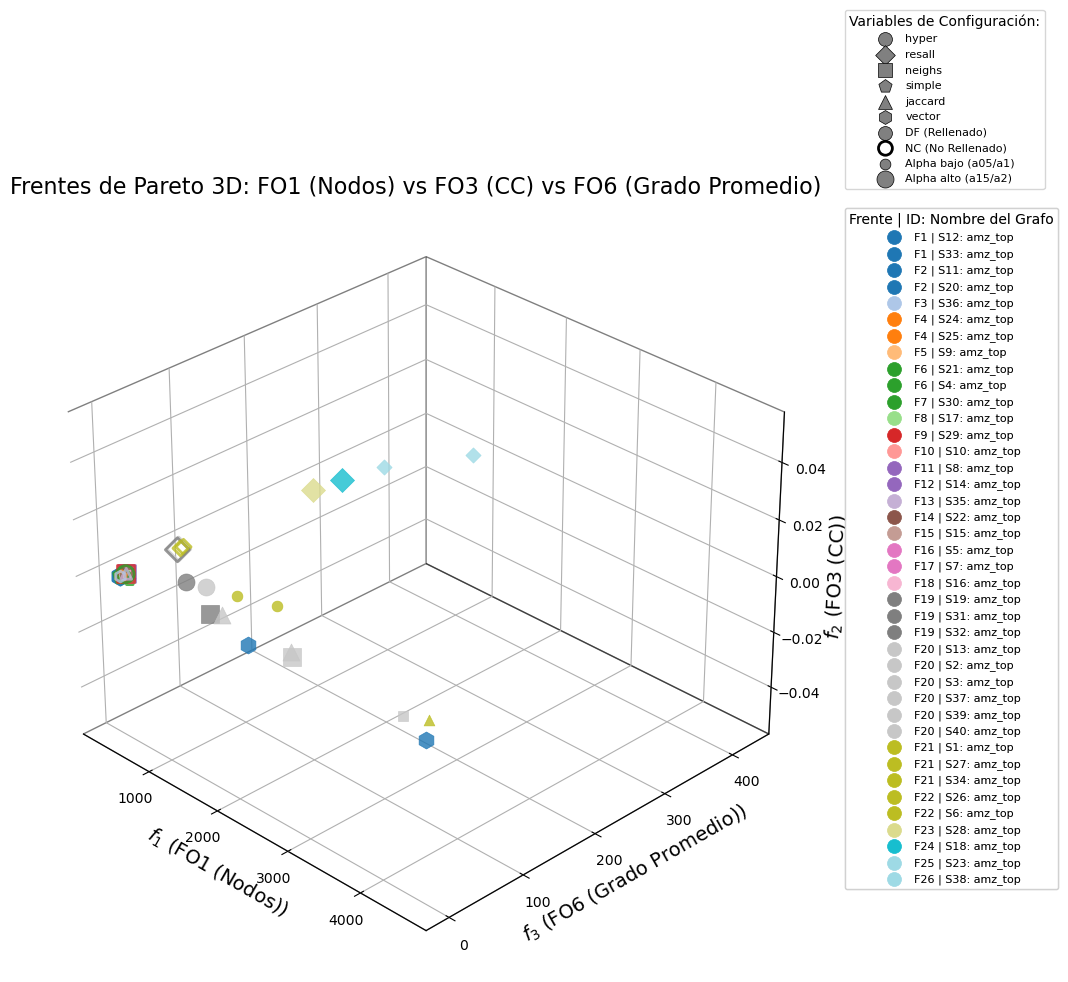


--- EVALUANDO 3D: FO1 (Nodos) vs FO4 (Power Law) vs FO5 (APL) ---
Soluciones factibles encontradas: 40


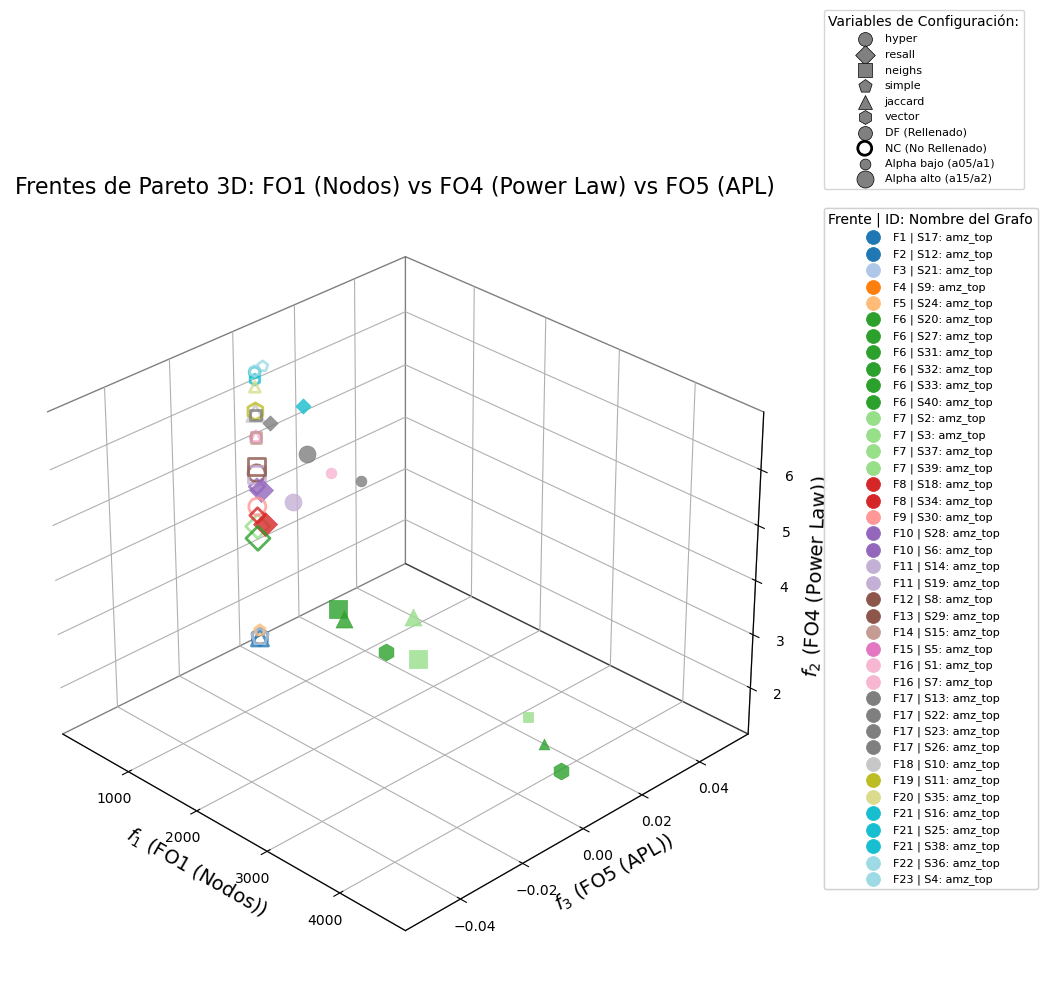


--- EVALUANDO 3D: FO1 (Nodos) vs FO4 (Power Law) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 40


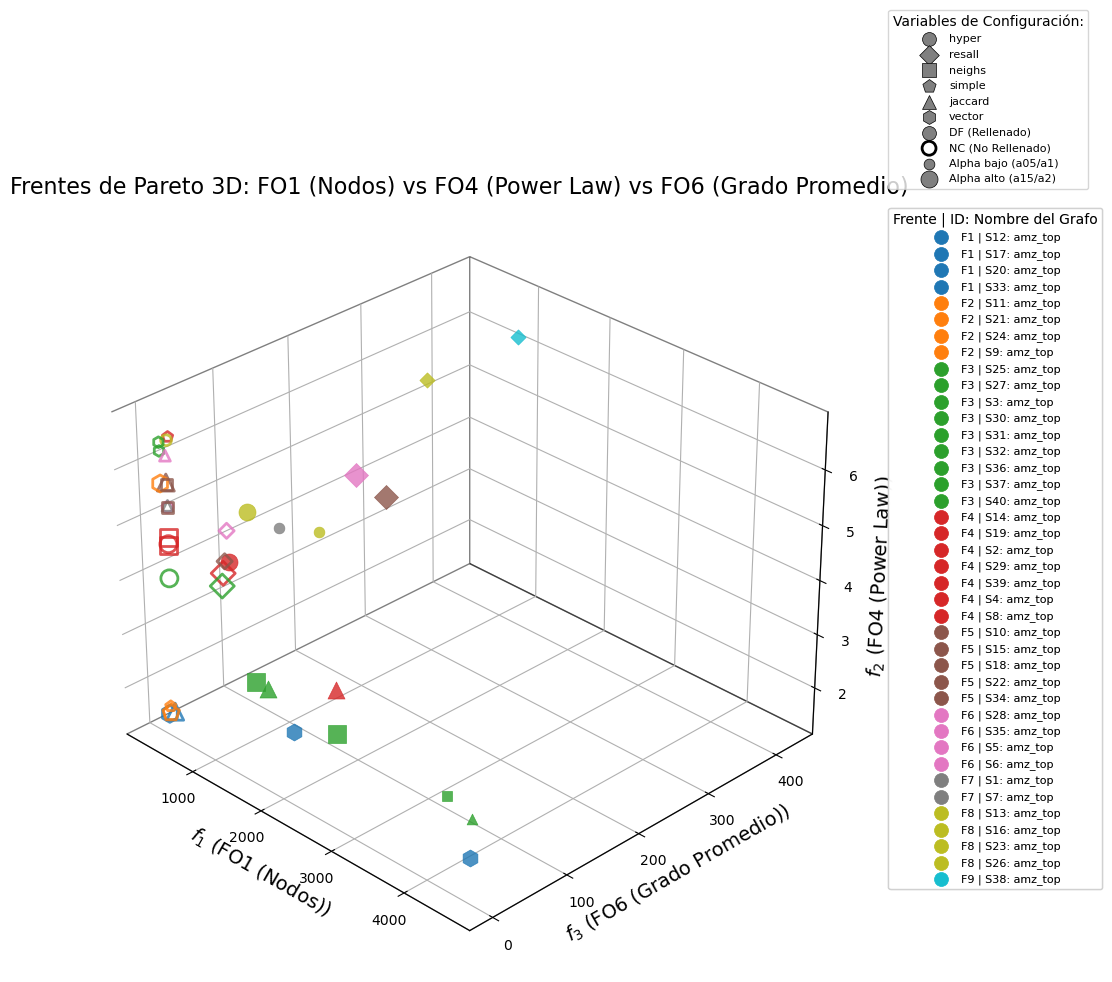


--- EVALUANDO 3D: FO1 (Nodos) vs FO5 (APL) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 40


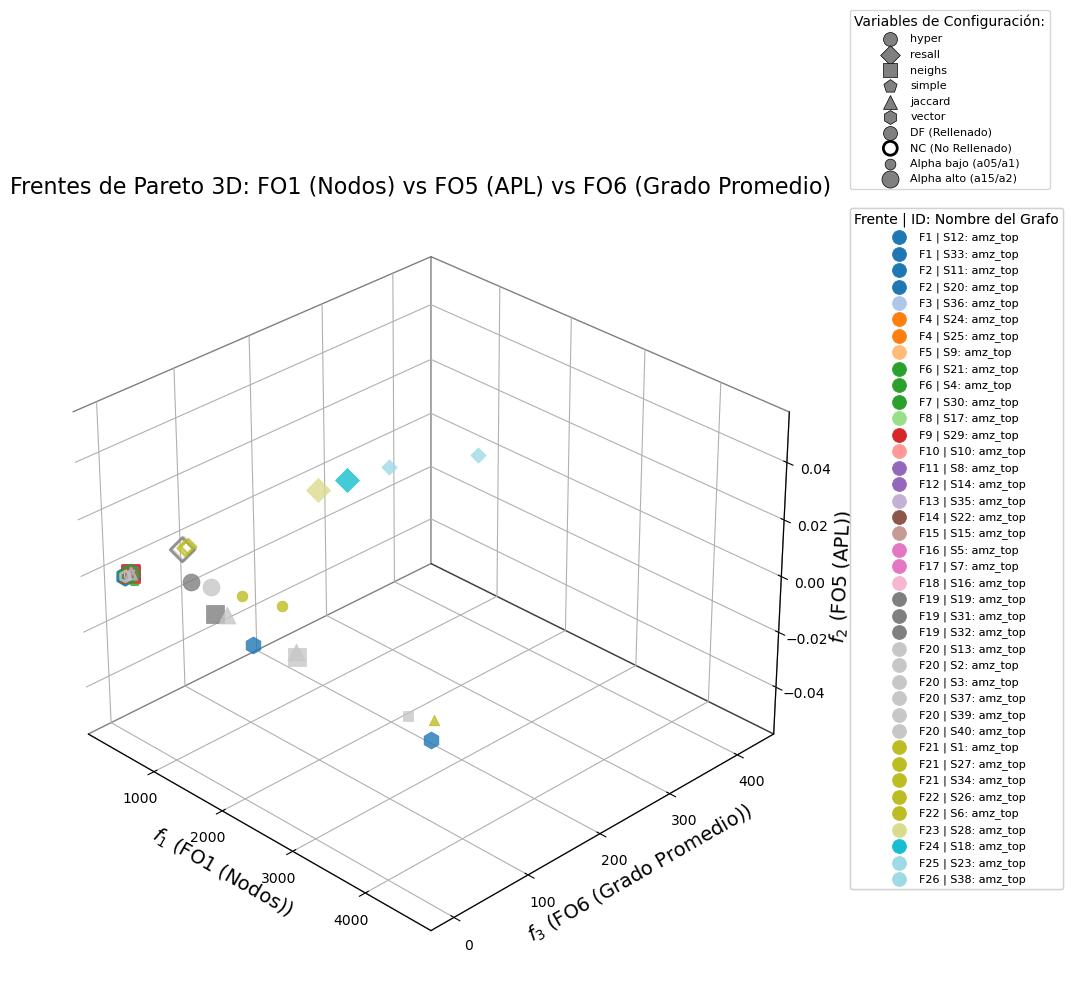


--- EVALUANDO 3D: FO2 (Densidad) vs FO3 (CC) vs FO4 (Power Law) ---
Soluciones factibles encontradas: 40


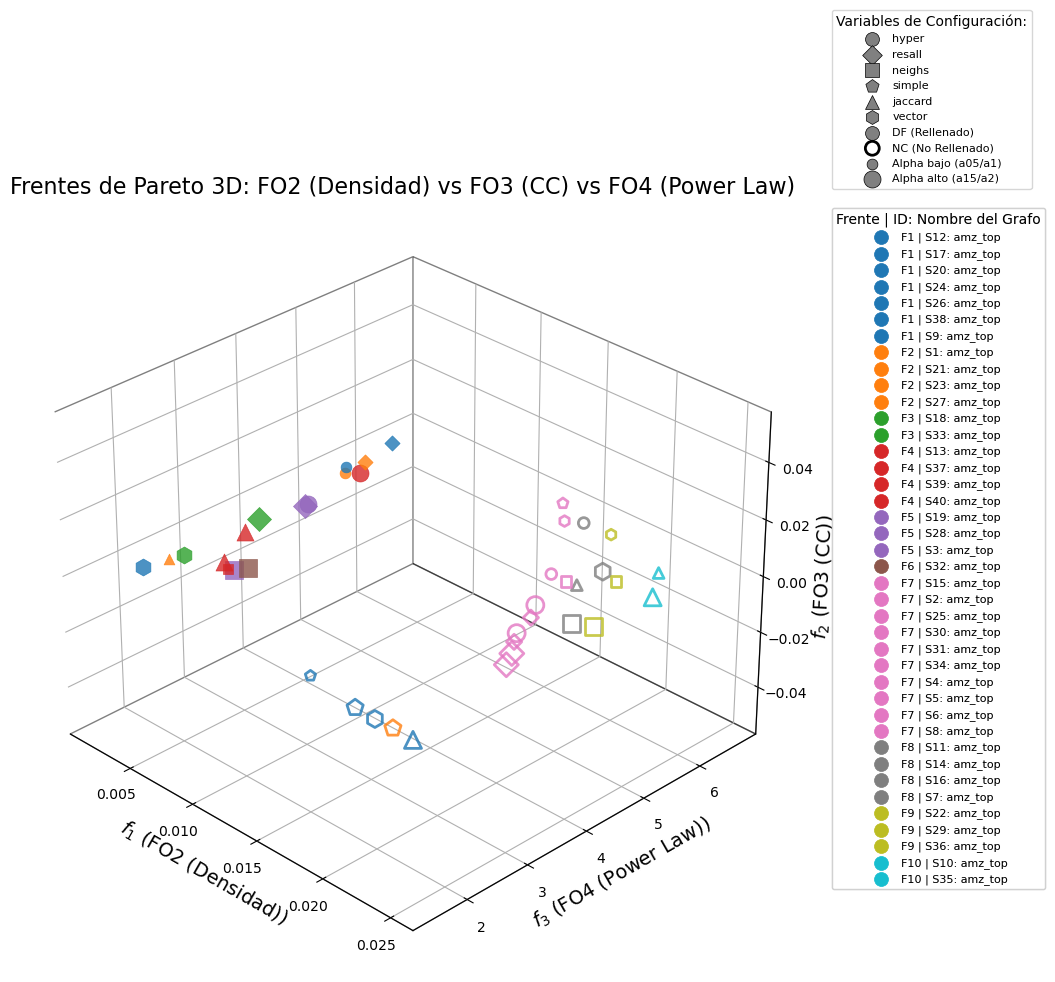


--- EVALUANDO 3D: FO2 (Densidad) vs FO3 (CC) vs FO5 (APL) ---
Soluciones factibles encontradas: 40


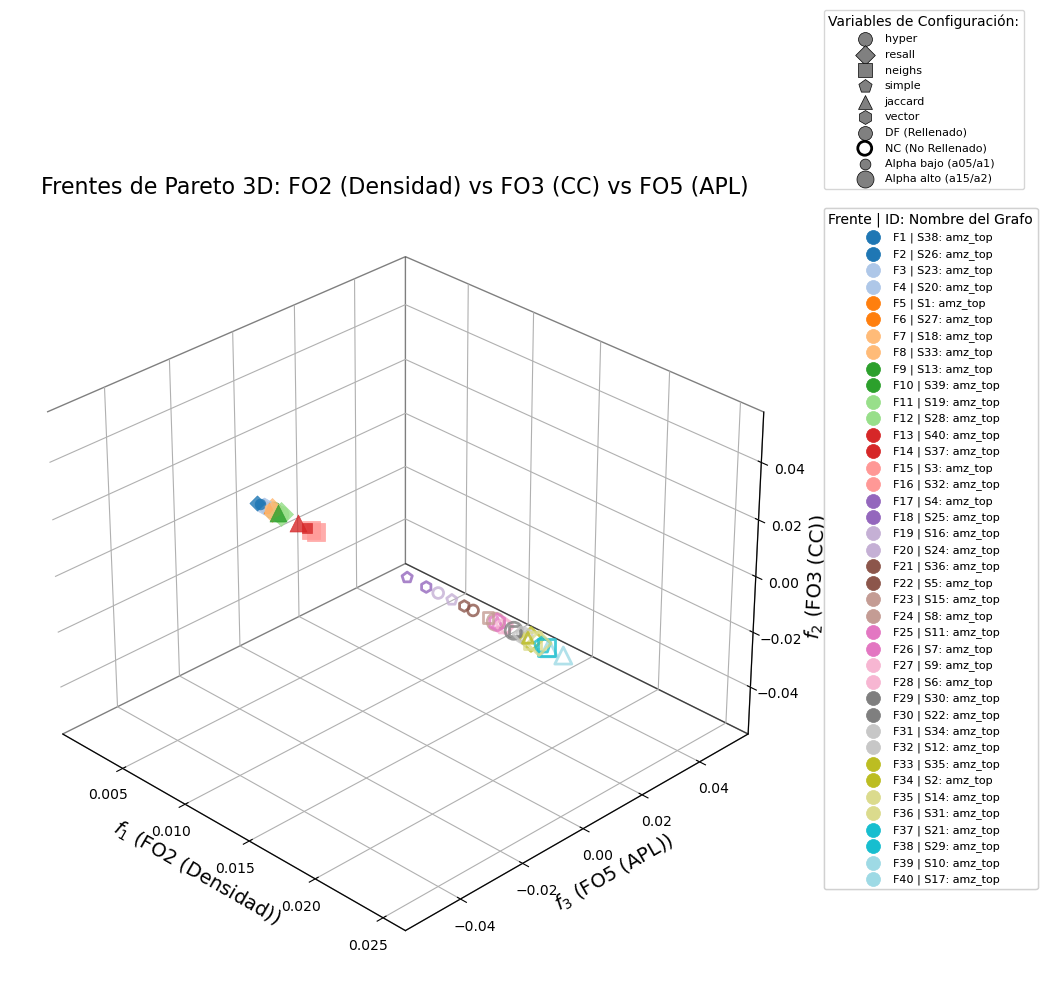


--- EVALUANDO 3D: FO2 (Densidad) vs FO3 (CC) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 40


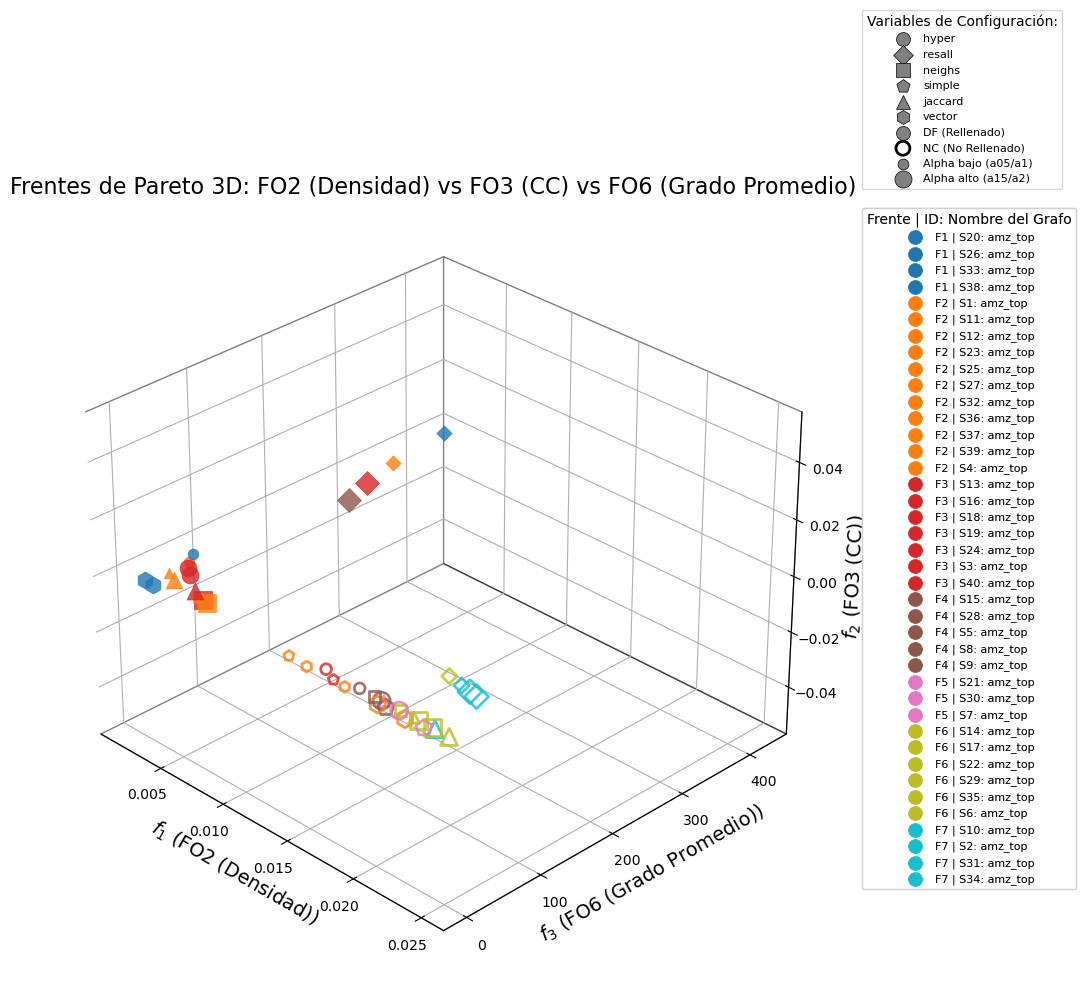


--- EVALUANDO 3D: FO2 (Densidad) vs FO4 (Power Law) vs FO5 (APL) ---
Soluciones factibles encontradas: 40


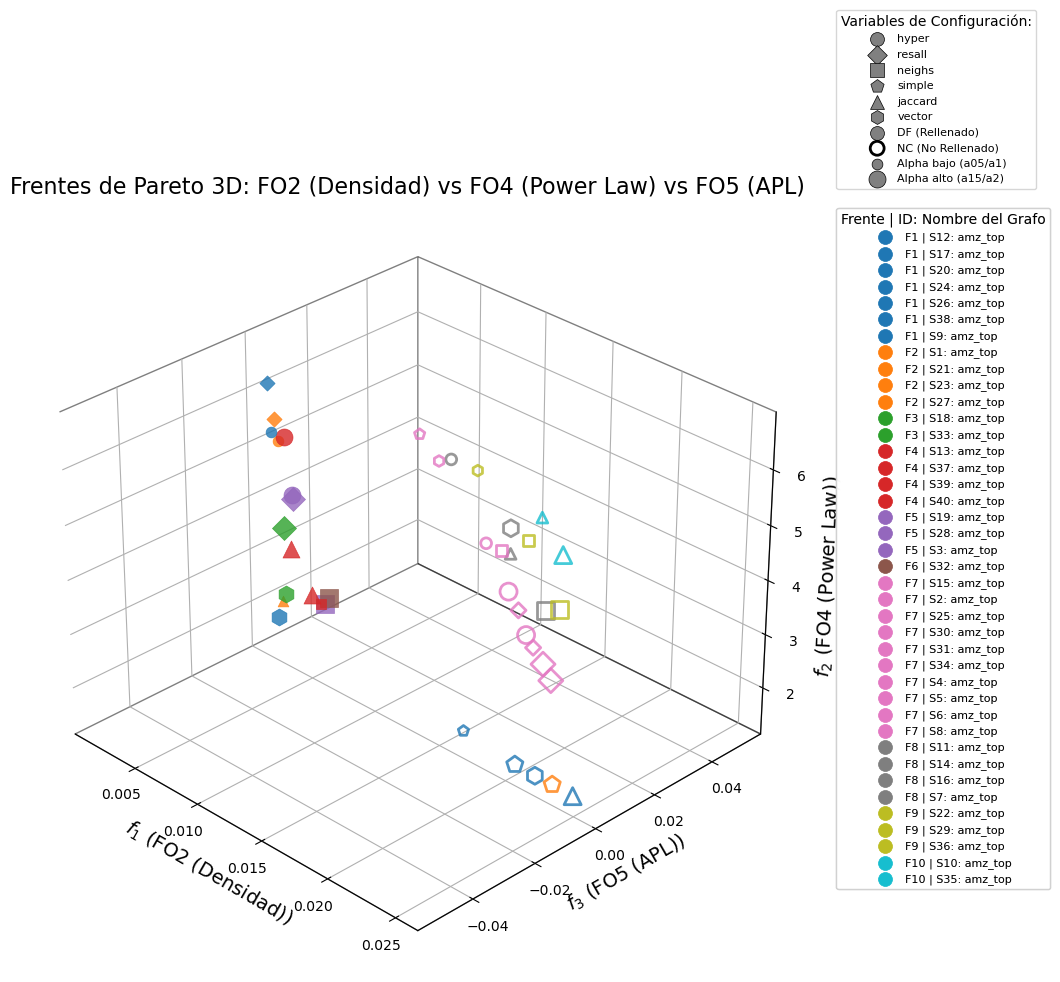


--- EVALUANDO 3D: FO2 (Densidad) vs FO4 (Power Law) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 40


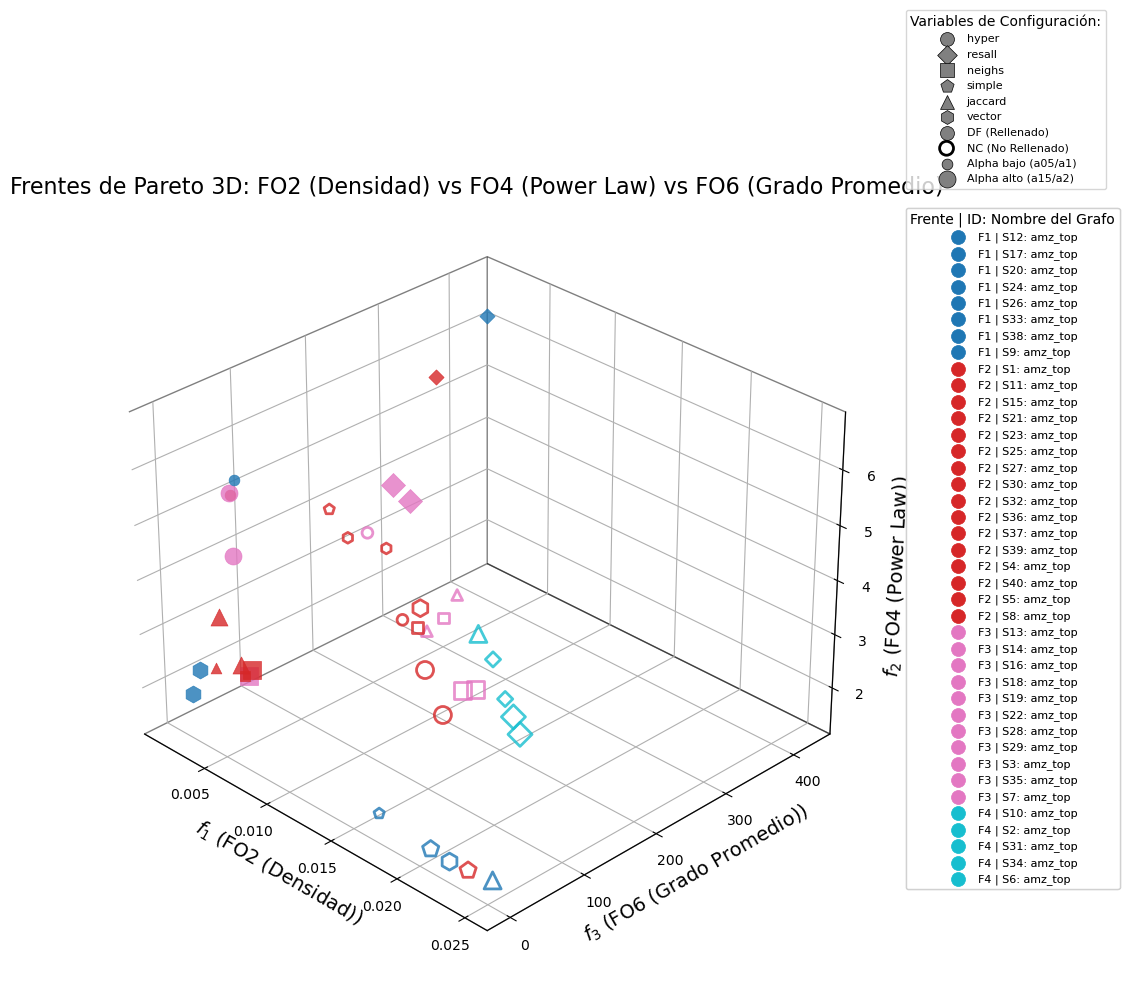


--- EVALUANDO 3D: FO2 (Densidad) vs FO5 (APL) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 40


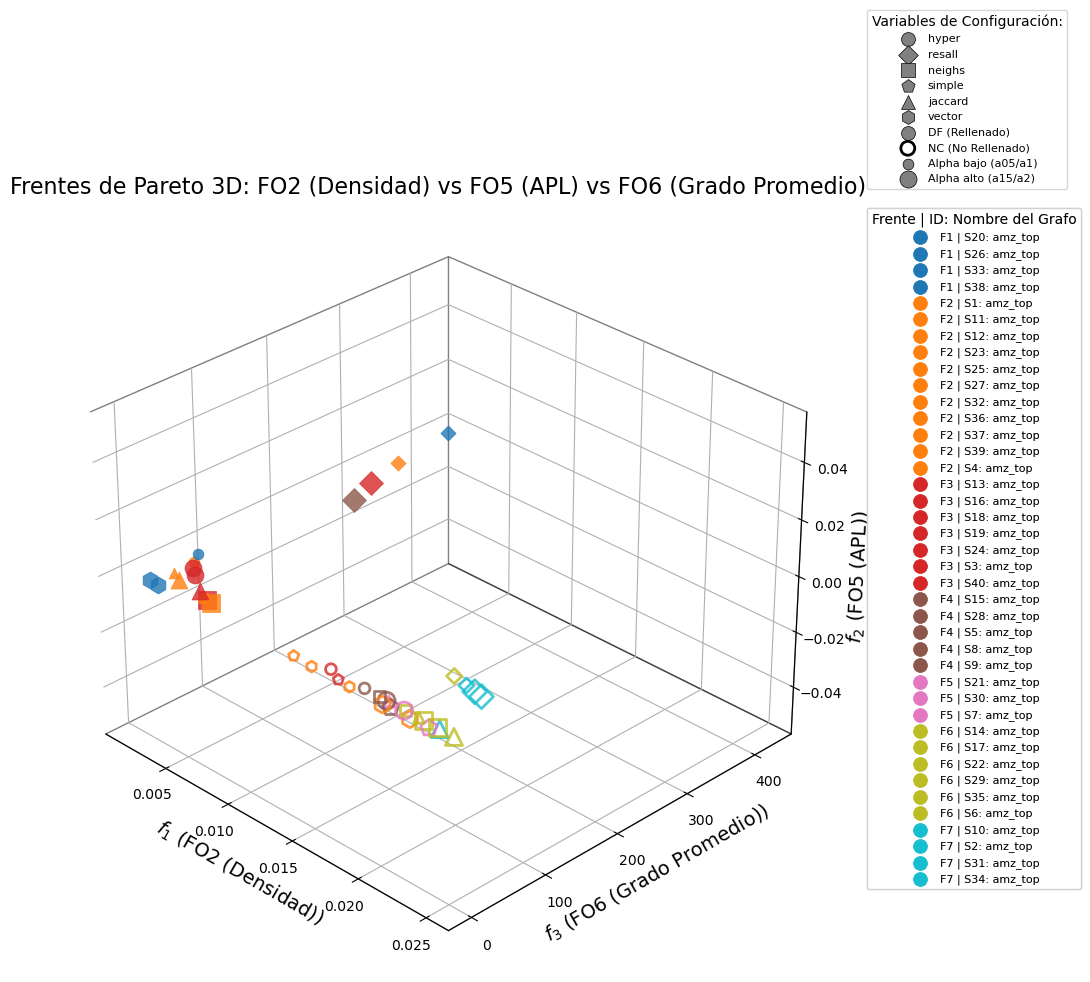


--- EVALUANDO 3D: FO3 (CC) vs FO4 (Power Law) vs FO5 (APL) ---
Soluciones factibles encontradas: 40


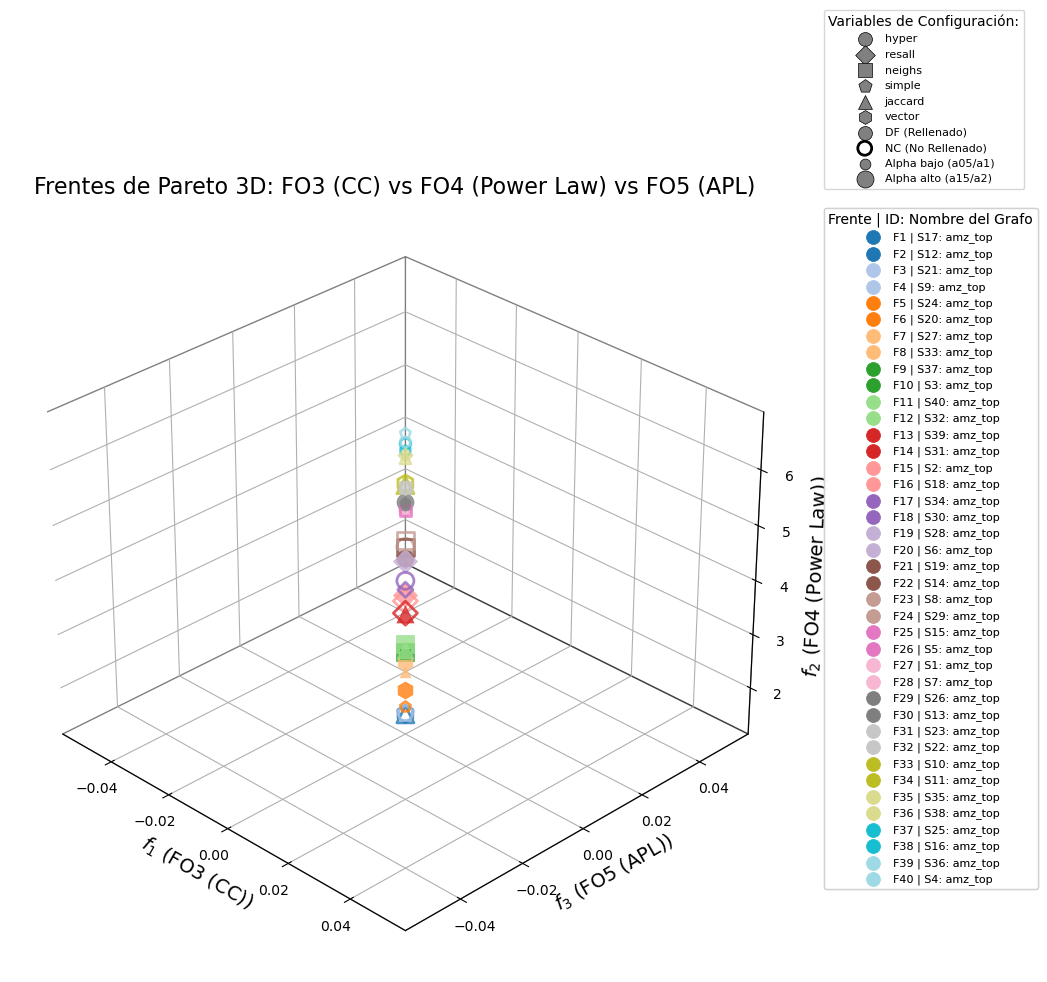


--- EVALUANDO 3D: FO3 (CC) vs FO4 (Power Law) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 40


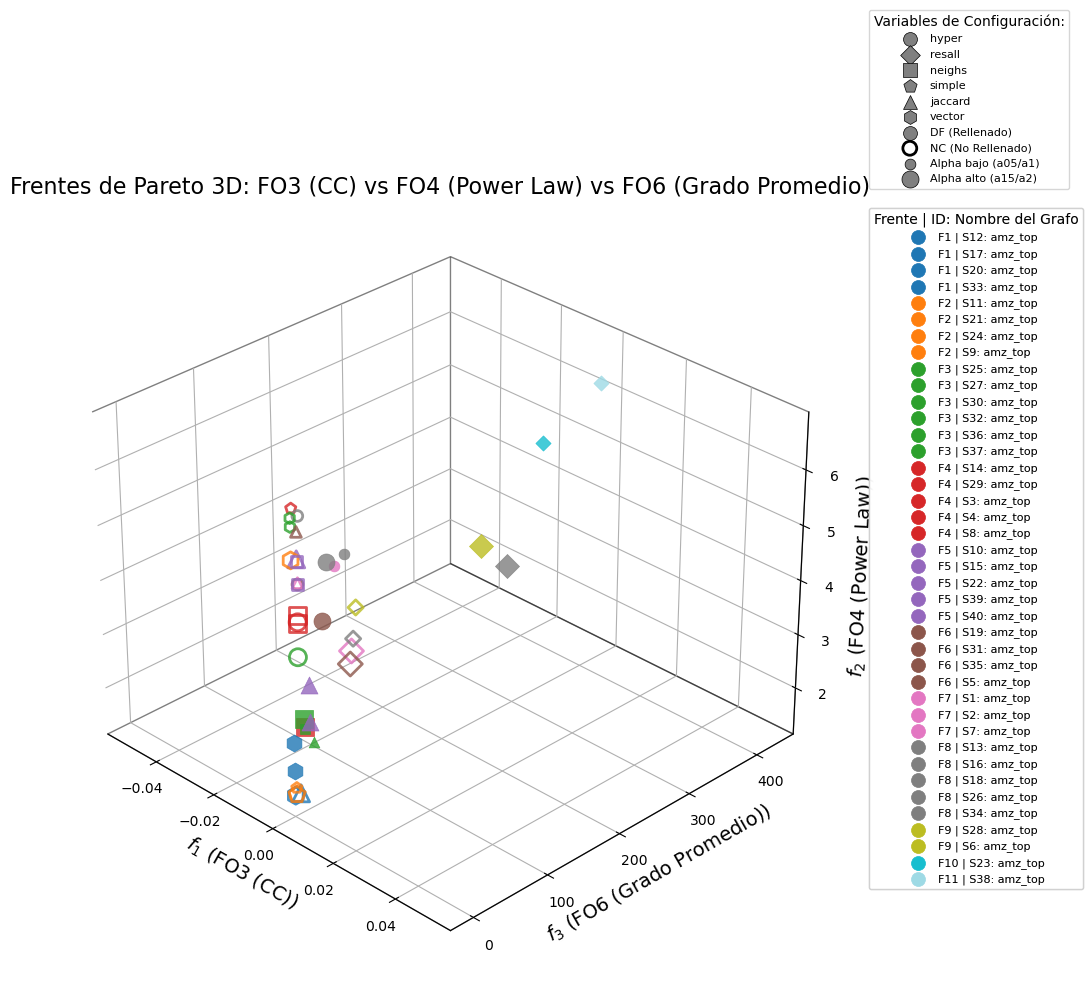


--- EVALUANDO 3D: FO3 (CC) vs FO5 (APL) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 40


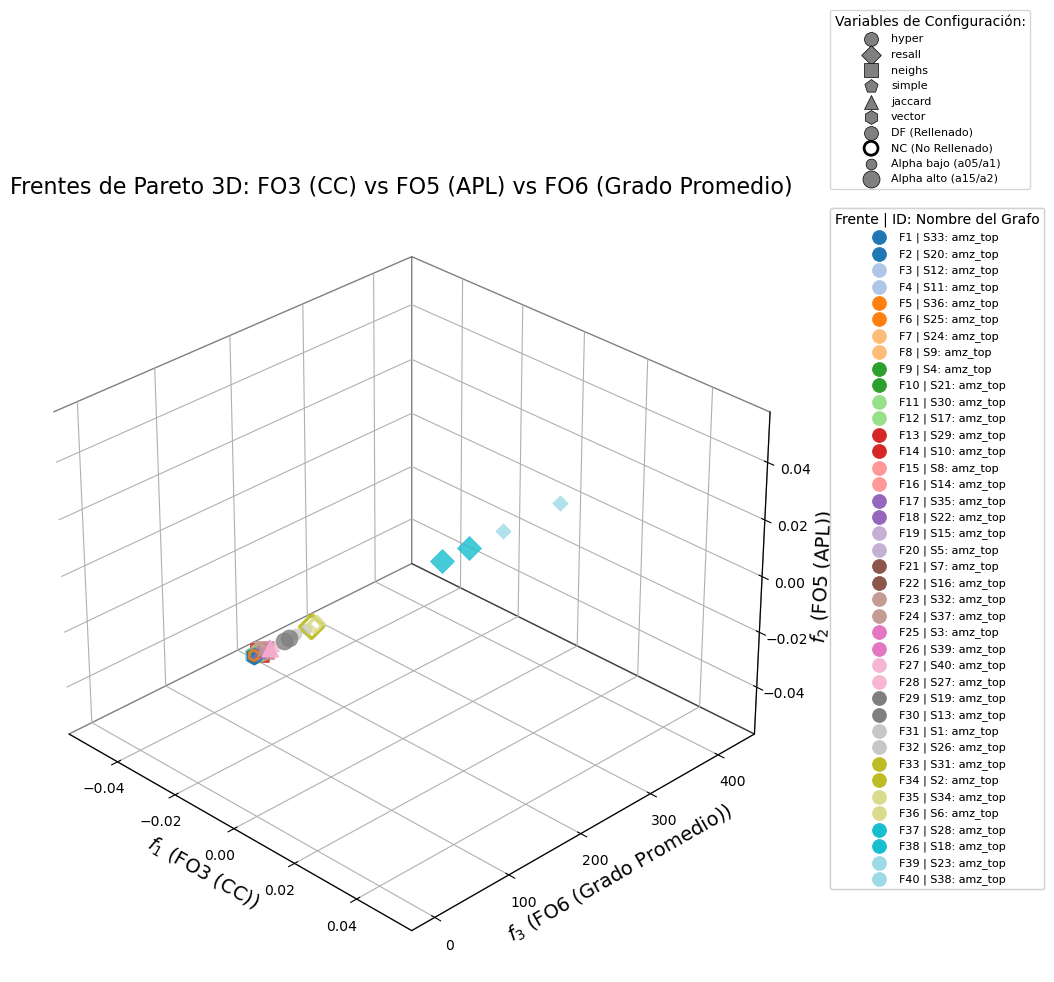


--- EVALUANDO 3D: FO4 (Power Law) vs FO5 (APL) vs FO6 (Grado Promedio) ---
Soluciones factibles encontradas: 40


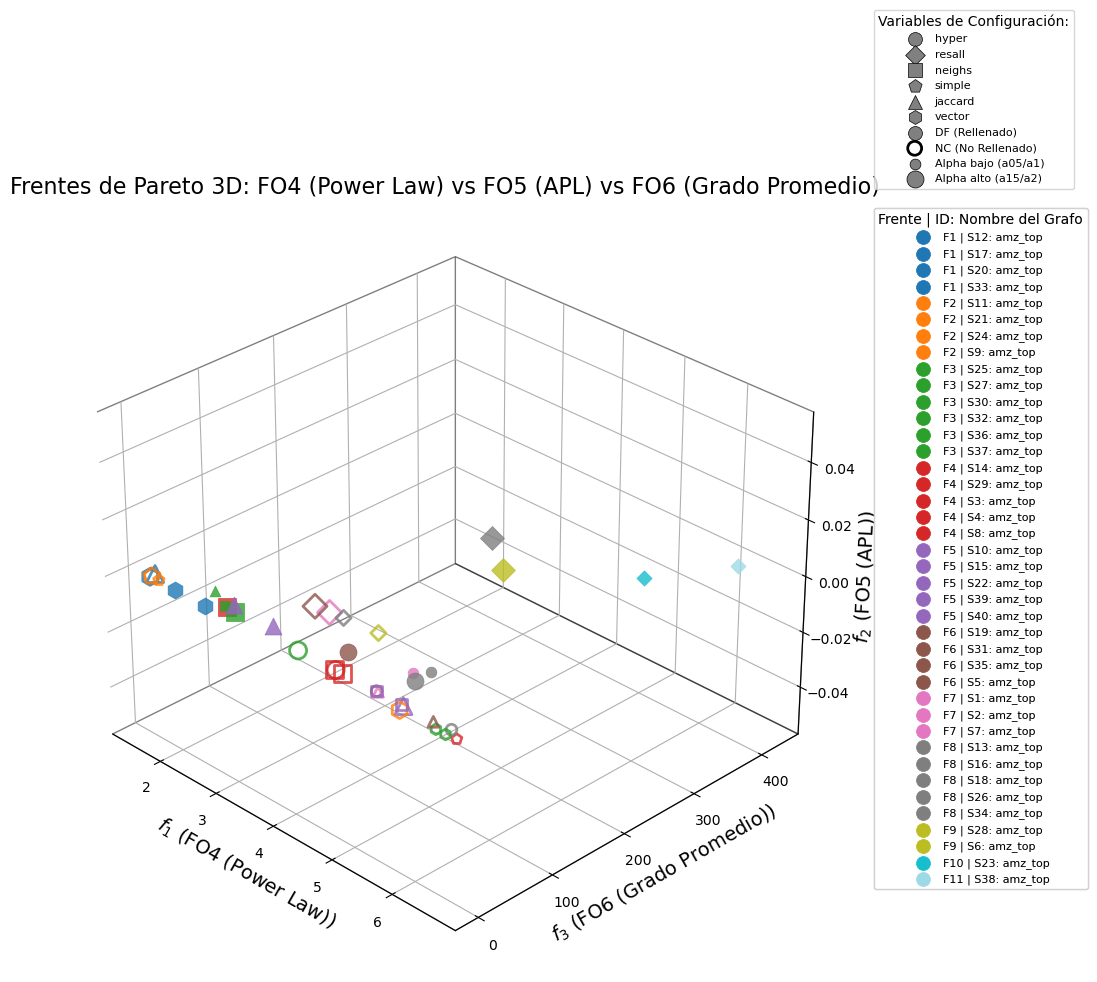

In [16]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]
# Definir los índices de las 6 FOs: [0, 1, 2, 3, 4, 5]
# FO1 = 0, FO2 = 1, FO3 = 2, FO4 = 3, FO5 = 4, FO6 = 5
import itertools 
# Asume que las variables DATASET, NODETYPE, bip_metrics, metrics_files, y os.path están definidas.

# Definir los índices de las 6 FOs: [0, 1, 2, 3, 4, 5]
FO_INDICES = list(range(6)) 

# Generar TODAS las combinaciones únicas de tríos (20 tríos)
METRIC_PAIRS_3D = list(itertools.combinations(FO_INDICES, 3))

# Nombres de las 6 FOs
FO_NAMES = ['FO1 (Nodos)', 'FO2 (Densidad)', 'FO3 (CC)', 'FO4 (Power Law)', 'FO5 (APL)', 'FO6 (Grado Promedio)']


# Bucle principal sobre las combinaciones de 3D
for metric_pair in METRIC_PAIRS_3D:
    
    f_index1, f_index2, f_index3 = metric_pair
    f_name1, f_name2, f_name3 = FO_NAMES[f_index1], FO_NAMES[f_index2], FO_NAMES[f_index3]
    
    print(f"\n--- EVALUANDO 3D: {f_name1} vs {f_name2} vs {f_name3} ---")
    
    solutions = []
    to_df = []
    names_df = []
    
    for fname in metrics_files:
        cache_path = os.path.join(metrics_cache_dir, fname)

        with open(cache_path, 'rb') as f:
            proj_metrics = pickle.load(f)

        base_name = fname.replace("_metrics.pkl", "")

        # LLAMADA CLAVE: Pasar el trío de métricas
        sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE, metric_pair)
        
        to_df.append(sol["f"])
        names_df.append(base_name)
        sol["filename"] = base_name

        if is_feasible(sol):
            solutions.append(sol)

    # Crear dataset final para el trío de métricas actual (f1, f2, f3)
    a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3']) # <--- AÑADIDO f3
    b = pd.DataFrame(names_df, columns=["name"])
    final_DF = pd.concat([a, b], axis=1)

    print(f"Soluciones factibles encontradas: {len(solutions)}")
    
    # -------------------------------------------------------------------------
    # Ejecutar Pareto Ranking y Plotting para el trío de métricas actual
    # -------------------------------------------------------------------------

    all_fronts = pareto_rank_all(solutions) # El ranking de Pareto funciona igual para 3+ objetivos
    
    plot_title = f"Frentes de Pareto 3D: {f_name1} vs {f_name2} vs {f_name3}"
    
    # Llamamos a la nueva función de plotting 3D
    plot_pareto_front_3d(final_DF, all_fronts, f_name1, f_name2, f_name3, plot_title)

# ... (Las funciones de Pareto Ranking siguen igual)

In [21]:
def plot_pareto_front(final_DF, all_fronts, xlabel_name, ylabel_name, plot_title):
    
    # ---------------------------------------------------------------------------------
    # CORRECCIÓN CLAVE: Asegurar la importación de librerías aquí
    # ---------------------------------------------------------------------------------
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np 
    import matplotlib.cm as cm # <--- ESTO ARREGLA NameError: name 'cm' is not defined
    
    # --- 1. PREPARACIÓN DE DATOS Y EXTRACCIÓN DE VARIABLES ---

    rank_map = {}
    for rank, front in enumerate(all_fronts, 1):
        for sol in front:
            rank_map[sol["filename"]] = rank 

    final_DF['rank'] = final_DF['name'].map(rank_map).fillna(0).astype(int) 
    plot_DF = final_DF[final_DF['rank'] > 0].copy()

    split_names = plot_DF['name'].str.split('_', expand=True)

    plot_DF['Proyeccion'] = split_names[2]
    plot_DF['Backbone'] = split_names[3]
    plot_DF['Alpha'] = split_names[4] 

    # --- 2. MAPEO DE ESTILOS VISUALES ---
    
    plot_DF['rank_str'] = plot_DF['rank'].astype(str)
    plot_DF['ID'] = 'S' + (plot_DF.reset_index().index + 1).astype(str)
    plot_DF['legend_label'] = plot_DF.apply(
        lambda row: f"F{row['rank_str']} | {row['ID']}: {row['name'].split('_')[0]}_{row['name'].split('_')[1]}", 
        axis=1
    )

    unique_projections = sorted(plot_DF['Proyeccion'].unique())
    marker_list = ['o', 's', '^', 'D', 'P', 'X', 'v', 'p', '*'] 
    PROJ_MARKERS = dict(zip(unique_projections, marker_list[:len(unique_projections)]))

    unique_backbones = sorted(plot_DF['Backbone'].unique())
    BB_FILLED_STATUS = dict(zip(unique_backbones, [True, False])) 
    plot_DF['is_filled'] = plot_DF['Backbone'].map(BB_FILLED_STATUS)

    unique_alphas = sorted(plot_DF['Alpha'].unique())
    if len(unique_alphas) >= 4:
        ALPHA_SIZES = {
            unique_alphas[0]: 60, unique_alphas[1]: 60,
            unique_alphas[2]: 150, unique_alphas[3]: 150
        }
        for alpha_val in unique_alphas[4:]: ALPHA_SIZES[alpha_val] = 150
    else:
        ALPHA_SIZES = {alpha: 100 for alpha in unique_alphas}
        
    plot_DF['size'] = plot_DF['Alpha'].map(ALPHA_SIZES)

    LINEWIDTH_BASE = 0.5   
    LINEWIDTH_INCREASED = 2.0
    
    # --- 3. COMIENZA LA GRÁFICA ---

    plt.figure(figsize=(14, 8)) 
    ax = plt.gca()

    unique_ranks = sorted(plot_DF['rank'].unique())
    num_unique_ranks = len(unique_ranks)
    # cm está definido gracias a la importación al inicio de la función
    cmap = cm.get_cmap('tab10' if num_unique_ranks <= 10 else 'tab20', num_unique_ranks) 

    legend_data = {}
    marker_handles = {}
    fill_handles = {}
    size_handles = {} 

    # 3a. Graficar los puntos
    for index, row in plot_DF.iterrows():
        
        rank_int = row['rank']
        color = cmap(rank_int - 1)
        
        # Configuración de relleno y borde
        if row['is_filled']:
            facecolor = color 
            edgecolor_val = color 
            linewidth_val = LINEWIDTH_BASE 
        else:
            facecolor = 'none' 
            edgecolor_val = color 
            linewidth_val = LINEWIDTH_INCREASED 
        
        # Graficar el punto:
        ax.scatter(
            row['f1'],
            row['f2'],
            s=row['size'],             
            alpha=0.8,
            edgecolors=edgecolor_val,
            linewidths=linewidth_val,
            marker=PROJ_MARKERS[row['Proyeccion']], 
            color=color,           
            facecolors=facecolor 
        )
        
        # Recolección de handles para las LEYENDAS (omitiendo duplicados)
        legend_data[row['ID']] = {'color': color, 'label': row['legend_label']}
        
        marker_handles[row['Proyeccion']] = ax.scatter([], [], marker=PROJ_MARKERS[row['Proyeccion']], color='gray', s=100, label=row['Proyeccion'], facecolors='gray', edgecolors='black', linewidths=LINEWIDTH_BASE)
        
        if row['is_filled'] and row['Backbone'] not in fill_handles:
            fill_handles[row['Backbone']] = ax.scatter([], [], marker='o', color='gray', s=100, facecolors='gray', edgecolors='black', label=f'{row["Backbone"]} (Rellenado)', linewidths=LINEWIDTH_BASE)
        elif not row['is_filled'] and row['Backbone'] not in fill_handles: 
            fill_handles[row['Backbone']] = ax.scatter([], [], marker='o', color='gray', s=100, facecolors='none', edgecolors='black', label=f'{row["Backbone"]} (No Rellenado)', linewidths=LINEWIDTH_INCREASED)
            
        if row['size'] == 60 and 'Small' not in size_handles:
            size_handles['Small'] = ax.scatter([], [], marker='o', color='gray', s=60, edgecolors='black', facecolors='gray', label=f'Alpha bajo ({unique_alphas[0]}/{unique_alphas[1]})', linewidths=LINEWIDTH_BASE)
        elif row['size'] == 150 and 'Large' not in size_handles:
            size_handles['Large'] = ax.scatter([], [], marker='o', color='gray', s=150, edgecolors='black', facecolors='gray', label=f'Alpha alto ({unique_alphas[2]}/{unique_alphas[3]})', linewidths=LINEWIDTH_BASE)


    # 3b. Crear LEYENDA PRINCIPAL (Frente/ID)
    legend_handles_main = []
    sorted_ids = plot_DF.sort_values(by=['rank', 'ID'])['ID'].tolist()

    for id_key in sorted_ids:
        data = legend_data[id_key]
        proxy = ax.scatter([], [], 
                           c=[data['color']], 
                           label=data['label'], 
                           s=100, 
                           edgecolors=data['color'], 
                           facecolors=data['color'],
                           linewidths=LINEWIDTH_BASE) 
        legend_handles_main.append(proxy)


    # Colocamos la LEYENDA PRINCIPAL
    legend_main = ax.legend(handles=legend_handles_main, 
              title="Frente | ID: Nombre del Grafo", 
              loc='upper left', 
              bbox_to_anchor=(1.05, 1), 
              fontsize=8)


    # 3c. Crear LEYENDAS AUXILIARES (Forma, Relleno, Tamaño)
    all_handles = []

    all_handles.extend(marker_handles.values())
    all_handles.extend(fill_handles.values())
    all_handles.extend(size_handles.values()) 

    # Colocamos la LEYENDA AUXILIAR (JUSTO ARRIBA)
    legend_aux = ax.legend(handles=all_handles, 
                        title="Variables de Configuración:", 
                        loc='lower left', 
                        bbox_to_anchor=(1.05, 1.01),
                        fontsize=8)
    
    ax.add_artist(legend_aux)
    ax.add_artist(legend_main)

    # 3d. Añadir Anotaciones de Texto (ID)
    for index, row in plot_DF.iterrows():
        ax.annotate(
            row['ID'],  
            (row['f1'], row['f2']),
            textcoords="offset points", 
            xytext=(5, 5),
            ha='left', 
            fontsize=9,
            weight='bold' 
        )

    # 3e. Finalizar el Gráfico
    ax.set_title(plot_title, fontsize=16)
    ax.set_xlabel(f'$f_1$ ({xlabel_name})', fontsize=14)
    ax.set_ylabel(f'$f_2$ ({ylabel_name})', fontsize=14)
    plt.subplots_adjust(right=0.7) 
    ax.grid(True, linestyle=':', alpha=0.7)

    plt.show()

In [20]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)

#analizar_frente(counter_sols, DATASET.upper()+" Top")


Frente 1 (4 soluciones):
resall_DF_a15
resall_DF_a1
resall_NC_a1
resall_DF_a05

Frente 2 (5 soluciones):
resall_NC_a15
hyper_DF_a05
resall_DF_a2
hyper_NC_a2
jaccard_DF_a15

Frente 3 (5 soluciones):
hyper_DF_a1
resall_NC_a05
hyper_DF_a15
hyper_DF_a2
resall_NC_a2

Frente 4 (3 soluciones):
hyper_NC_a15
neighs_NC_a15
neighs_DF_a2

Frente 5 (3 soluciones):
neighs_DF_a15
neighs_NC_a2
jaccard_DF_a2

Frente 6 (1 soluciones):
neighs_DF_a1

Frente 7 (1 soluciones):
vector_DF_a2

Frente 8 (3 soluciones):
hyper_NC_a1
neighs_NC_a05
vector_DF_a15

Frente 9 (4 soluciones):
jaccard_NC_a05
vector_NC_a15
neighs_NC_a1
vector_NC_a1

Frente 10 (6 soluciones):
jaccard_NC_a15
vector_NC_a2
hyper_NC_a05
simple_NC_a1
vector_NC_a05
jaccard_DF_a1

Frente 11 (2 soluciones):
simple_NC_a15
jaccard_NC_a1

Frente 12 (3 soluciones):
simple_NC_a05
jaccard_NC_a2
simple_NC_a2


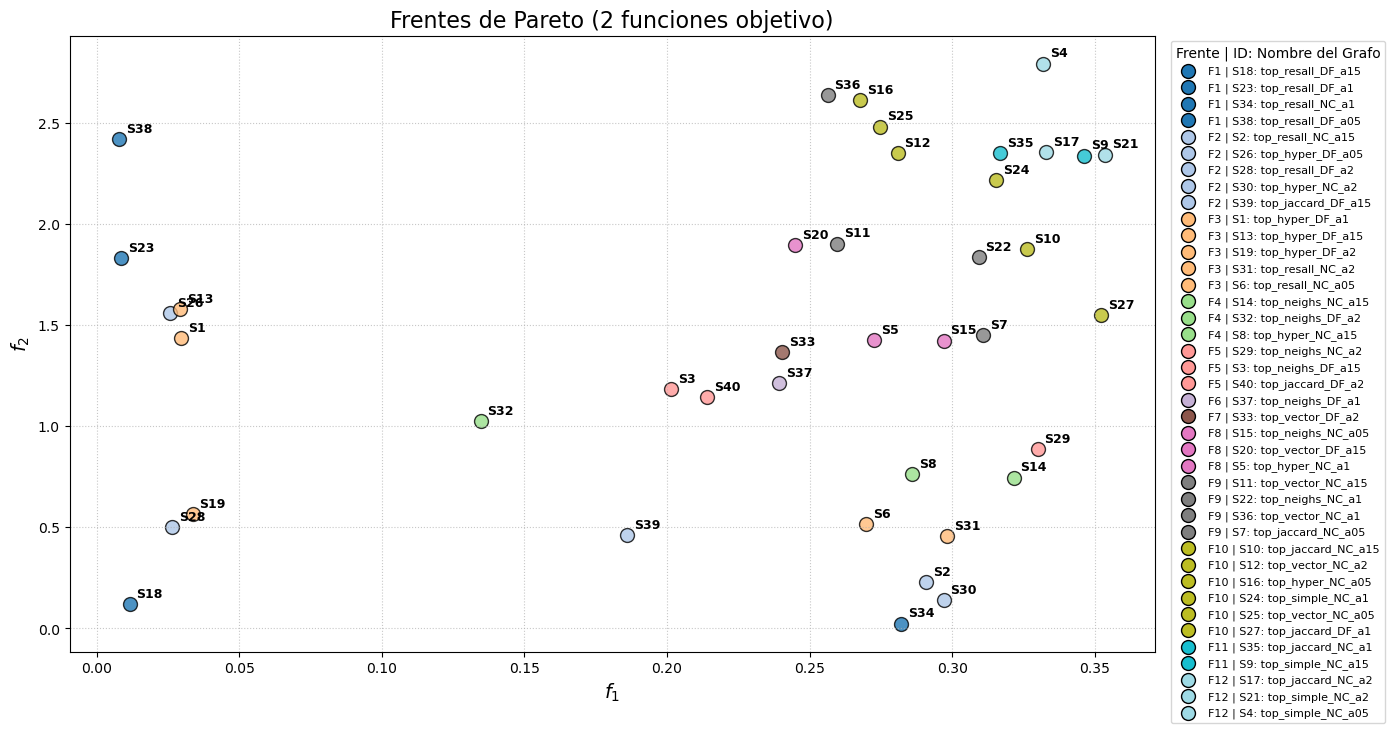

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.cm as cm

# -------------------------------------------------------------
# ASUMIMOS QUE ESTE PUNTO DEL CÓDIGO YA SE HA EJECUTADO:
# - final_DF está creado con 'f1', 'f2', 'name'.
# - solutions está lleno.
# - all_fronts está calculado.
# -------------------------------------------------------------

# --- 1. PREPARACIÓN DE DATOS Y ASIGNACIÓN DE RANKS (Reutilizamos el código robusto) ---

rank_map = {}
for rank, front in enumerate(all_fronts, 1):
    for sol in front:
        rank_map[sol["filename"]] = rank

final_DF['rank'] = final_DF['name'].map(rank_map).fillna(0).astype(int) 

plot_DF = final_DF[final_DF['rank'] > 0].copy()
plot_DF['rank_str'] = plot_DF['rank'].astype(str)
plot_DF['ID'] = 'S' + (plot_DF.reset_index().index + 1).astype(str)
plot_DF['legend_label'] = plot_DF.apply(
    lambda row: f"F{row['rank_str']} | {row['ID']}: {row['name'][4:]}", 
    axis=1
)

# --- 2. GENERAR LA GRÁFICA CON MATPLOTLIB (CORRECCIÓN DE COLOR) ---

plt.figure(figsize=(14, 8)) 

# Obtener los frentes únicos y ordenarlos
unique_ranks = sorted(plot_DF['rank'].unique())
num_unique_ranks = len(unique_ranks)

# Usamos un mapa de color más distintivo si el número de frentes es pequeño
if num_unique_ranks <= 10:
    cmap = cm.get_cmap('tab10', num_unique_ranks)
else:
    cmap = cm.get_cmap('tab20', num_unique_ranks)
    #cmap = cm.get_cmap('tab10', num_unique_ranks)

# Diccionario para almacenar handles y etiquetas de la leyenda (para evitar duplicados)
legend_data = {}

# 3a. Graficar los puntos por FRENTE (Esto garantiza el mismo color por frente)
for rank_int in unique_ranks:
    
    # 1. Filtramos el subconjunto para el frente actual
    subset = plot_DF[plot_DF['rank'] == rank_int]
    
    # 2. Obtenemos el color
    color_index = rank_int - 1
    color = cmap(color_index)
    
    # 3. Graficar: Todos los puntos de este subset tendrán el mismo color
    plt.scatter(
        subset['f1'],
        subset['f2'],
        s=100,             
        alpha=0.8,
        edgecolors='black',
        color=color # Asignación de color directo
    )
    
    # Almacenamos handles y etiquetas para la leyenda detallada
    for index, row in subset.iterrows():
        legend_data[row['ID']] = {'color': color, 'label': row['legend_label']}

# 3b. Añadir Anotaciones de Texto (ID)
for index, row in plot_DF.iterrows():
    plt.annotate(
        row['ID'],  
        (row['f1'], row['f2']),
        textcoords="offset points", 
        xytext=(5, 5),
        ha='left', 
        fontsize=9,
        weight='bold' 
    )

# 3c. Crear la Leyenda detallada (Objetos Proxy)
legend_handles = []
# Ordenamos los IDs por rank para una leyenda lógica
sorted_ids = plot_DF.sort_values(by=['rank', 'ID'])['ID'].tolist()

for id_key in sorted_ids:
    data = legend_data[id_key]
    
    proxy = plt.scatter([], [], 
                        c=[data['color']], # c acepta lista o tupla para el color
                        label=data['label'], 
                        s=100, edgecolors='black')
    legend_handles.append(proxy)


# 3d. Finalizar el Gráfico
plt.title('Frentes de Pareto (2 funciones objetivo)', fontsize=16)
plt.xlabel('$f_1$', fontsize=14)
plt.ylabel('$f_2$', fontsize=14)

# Mover el recuadro del legend más a la derecha (loc='upper left', bbox_to_anchor=(1.01, 1))
plt.legend(handles=legend_handles, 
           title="Frente | ID: Nombre del Grafo", 
           loc='upper left', 
           bbox_to_anchor=(1.01, 1), 
           fontsize=8)

plt.grid(True, linestyle=':', alpha=0.7)

plt.show()

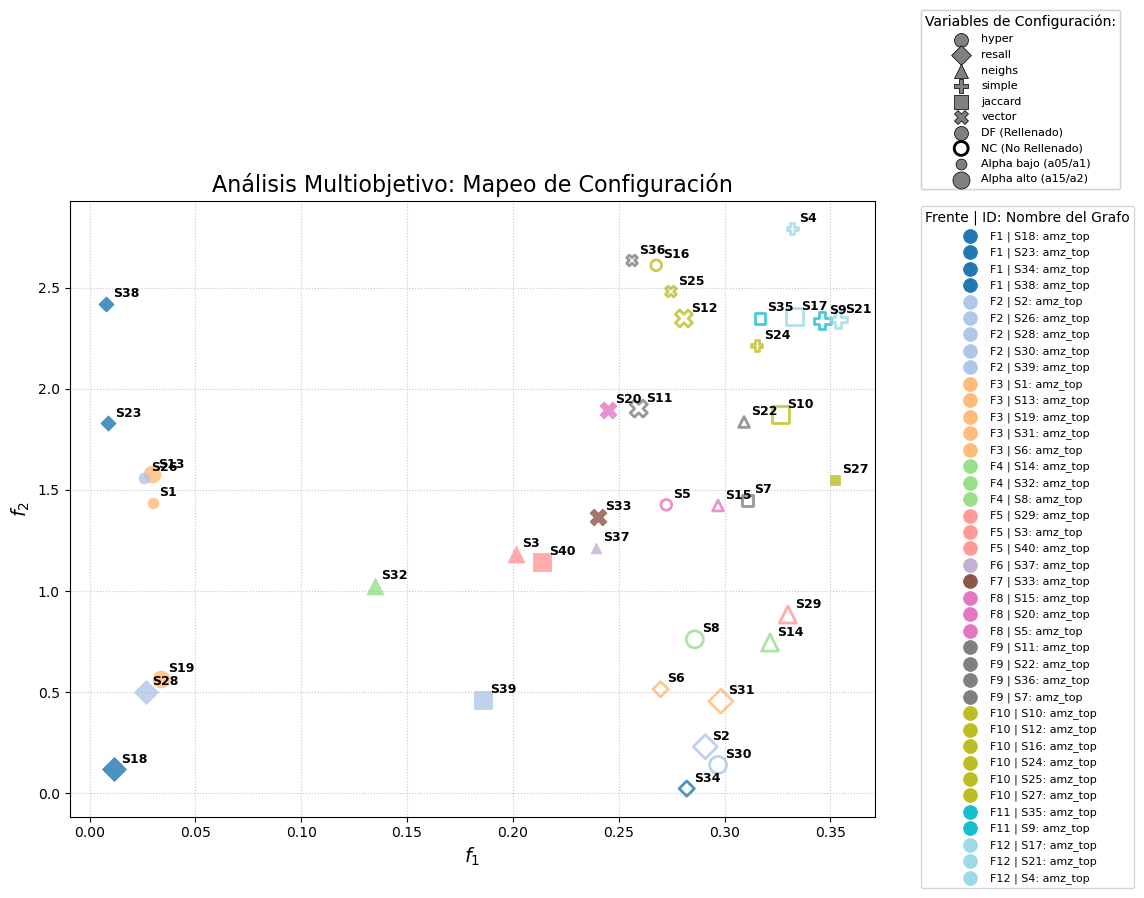

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.cm as cm

# -------------------------------------------------------------
# ASUMIMOS QUE ESTE PUNTO DEL CÓDIGO YA SE HA EJECUTADO:
# - final_DF está creado con 'f1', 'f2', 'name'.
# - solutions está lleno.
# - all_fronts está calculado.
# -------------------------------------------------------------

# --- 1. PREPARACIÓN DE DATOS Y EXTRACCIÓN DE VARIABLES (Sin cambios) ---

rank_map = {}
for rank, front in enumerate(all_fronts, 1):
    for sol in front:
        # CORRECCIÓN: Mapear el 'filename' al 'rank' (el valor entero)
        rank_map[sol["filename"]] = rank 

final_DF['rank'] = final_DF['name'].map(rank_map).fillna(0).astype(int) 
plot_DF = final_DF[final_DF['rank'] > 0].copy()

split_names = plot_DF['name'].str.split('_', expand=True)

plot_DF['Proyeccion'] = split_names[2]
plot_DF['Backbone'] = split_names[3]
plot_DF['Alpha'] = split_names[4] 

plot_DF['rank_str'] = plot_DF['rank'].astype(str)
plot_DF['ID'] = 'S' + (plot_DF.reset_index().index + 1).astype(str)
plot_DF['legend_label'] = plot_DF.apply(
    lambda row: f"F{row['rank_str']} | {row['ID']}: {row['name'].split('_')[0]}_{row['name'].split('_')[1]}", 
    axis=1
)

# --- 2. MAPEO DE ESTILOS VISUALES (Sin cambios) ---

unique_projections = sorted(plot_DF['Proyeccion'].unique())
marker_list = ['o', 's', '^', 'D', 'P', 'X', 'v', 'p', '*'] 
PROJ_MARKERS = dict(zip(unique_projections, marker_list[:len(unique_projections)]))

unique_backbones = sorted(plot_DF['Backbone'].unique())
BB_FILLED_STATUS = dict(zip(unique_backbones, [True, False])) 
plot_DF['is_filled'] = plot_DF['Backbone'].map(BB_FILLED_STATUS)

unique_alphas = sorted(plot_DF['Alpha'].unique())
if len(unique_alphas) >= 4:
    ALPHA_SIZES = {
        unique_alphas[0]: 60, unique_alphas[1]: 60,
        unique_alphas[2]: 150, unique_alphas[3]: 150
    }
    for alpha_val in unique_alphas[4:]: ALPHA_SIZES[alpha_val] = 150
else:
    ALPHA_SIZES = {alpha: 100 for alpha in unique_alphas}
    
plot_DF['size'] = plot_DF['Alpha'].map(ALPHA_SIZES)

# Definimos los grosores de línea base y aumentado
LINEWIDTH_BASE = 0.5   
LINEWIDTH_INCREASED = 2.0

# --- 3. GENERAR LA GRÁFICA CON MATPLOTLIB (MODIFICADO LA POSICIÓN DE LEYENDAS) ---

plt.figure(figsize=(14, 8)) 
ax = plt.gca()

unique_ranks = sorted(plot_DF['rank'].unique())
num_unique_ranks = len(unique_ranks)
cmap = cm.get_cmap('tab10' if num_unique_ranks <= 10 else 'tab20', num_unique_ranks)

legend_data = {}
marker_handles = {}
fill_handles = {}
size_handles = {} 

# 3a. Graficar los puntos
for index, row in plot_DF.iterrows():
    
    rank_int = row['rank']
    color = cmap(rank_int - 1)
    
    # Configuración de relleno y borde
    if row['is_filled']:
        facecolor = color 
        edgecolor_val = color 
        linewidth_val = LINEWIDTH_BASE 
    else:
        facecolor = 'none' 
        edgecolor_val = color 
        linewidth_val = LINEWIDTH_INCREASED 
    
    # Graficar el punto:
    ax.scatter(
        row['f1'],
        row['f2'],
        s=row['size'],             
        alpha=0.8,
        edgecolors=edgecolor_val,
        linewidths=linewidth_val,
        marker=PROJ_MARKERS[row['Proyeccion']], 
        color=color,           
        facecolors=facecolor 
    )
    
    # Recolección de handles para las LEYENDAS
    legend_data[row['ID']] = {'color': color, 'label': row['legend_label']}
    
    # Recolección de handles AUXILIARES (omitiendo duplicados)
    marker_handles[row['Proyeccion']] = ax.scatter([], [], marker=PROJ_MARKERS[row['Proyeccion']], color='gray', s=100, label=row['Proyeccion'], facecolors='gray', edgecolors='black', linewidths=LINEWIDTH_BASE)
    
    if row['is_filled'] and row['Backbone'] not in fill_handles:
        fill_handles[row['Backbone']] = ax.scatter([], [], marker='o', color='gray', s=100, facecolors='gray', edgecolors='black', label=f'{row["Backbone"]} (Rellenado)', linewidths=LINEWIDTH_BASE)
    elif not row['is_filled'] and row['Backbone'] not in fill_handles: 
        fill_handles[row['Backbone']] = ax.scatter([], [], marker='o', color='gray', s=100, facecolors='none', edgecolors='black', label=f'{row["Backbone"]} (No Rellenado)', linewidths=LINEWIDTH_INCREASED)
        
    if row['size'] == 60 and 'Small' not in size_handles:
        size_handles['Small'] = ax.scatter([], [], marker='o', color='gray', s=60, edgecolors='black', facecolors='gray', label=f'Alpha bajo ({unique_alphas[0]}/{unique_alphas[1]})', linewidths=LINEWIDTH_BASE)
    elif row['size'] == 150 and 'Large' not in size_handles:
        size_handles['Large'] = ax.scatter([], [], marker='o', color='gray', s=150, edgecolors='black', facecolors='gray', label=f'Alpha alto ({unique_alphas[2]}/{unique_alphas[3]})', linewidths=LINEWIDTH_BASE)


# 3b. Crear LEYENDA PRINCIPAL (Frente/ID)
legend_handles_main = []
sorted_ids = plot_DF.sort_values(by=['rank', 'ID'])['ID'].tolist()

for id_key in sorted_ids:
    data = legend_data[id_key]
    proxy = ax.scatter([], [], 
                       c=[data['color']], 
                       label=data['label'], 
                       s=100, 
                       edgecolors=data['color'], 
                       facecolors=data['color'],
                       linewidths=LINEWIDTH_BASE) 
    legend_handles_main.append(proxy)


# Colocamos la LEYENDA PRINCIPAL
legend_main = ax.legend(handles=legend_handles_main, 
          title="Frente | ID: Nombre del Grafo", 
          loc='upper left', 
          # Colocación justo fuera de la esquina superior derecha
          bbox_to_anchor=(1.05, 1), 
          fontsize=8)


# 3c. Crear LEYENDAS AUXILIARES (Forma, Relleno, Tamaño)
all_handles = []

all_handles.extend(marker_handles.values())
all_handles.extend(fill_handles.values())
all_handles.extend(size_handles.values()) 

# Colocamos la LEYENDA AUXILIAR justo arriba de la principal
legend_aux = ax.legend(handles=all_handles, 
                    title="Variables de Configuración:", 
                    loc='lower left', # Usamos lower left para anclar al bbox inferior
                    bbox_to_anchor=(1.05, 1.01), # Posición justo encima de la principal
                    fontsize=8)
# Agregamos la leyenda auxiliar *antes* de la principal para que no la tape
ax.add_artist(legend_aux)
ax.add_artist(legend_main) # Añadimos la principal después

# 3d. Añadir Anotaciones de Texto (ID)
for index, row in plot_DF.iterrows():
    ax.annotate(
        row['ID'],  
        (row['f1'], row['f2']),
        textcoords="offset points", 
        xytext=(5, 5),
        ha='left', 
        fontsize=9,
        weight='bold' 
    )

# 3e. Finalizar el Gráfico
ax.set_title('Análisis Multiobjetivo: Mapeo de Configuración', fontsize=16)
ax.set_xlabel('$f_1$', fontsize=14)
ax.set_ylabel('$f_2$', fontsize=14)
plt.subplots_adjust(right=0.7) # Ajustar el espacio a la derecha para que quepan las leyendas
ax.grid(True, linestyle=':', alpha=0.7)

plt.show()

Matriz de correlación:
          f1        f2
f1  1.000000  0.107438
f2  0.107438  1.000000


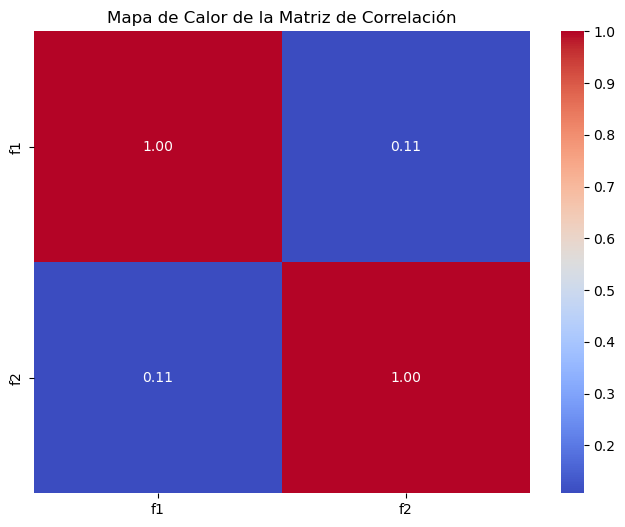

In [9]:
# Calculamos la matriz de correlación
correlation_matrix = final_DF[final_DF.columns[:-2]].corr()

print("Matriz de correlación:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Usamos la matriz de correlación que calculamos antes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

In [9]:
NODETYPE = 1    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
#bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics = {'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426, 'x15': gb.density(), 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 9561,
 'x2': 7518,
 'x3': 32769,
 'x8': 0.245,
 'x9': 5.628737133833499,
 'x11': 3.8553228787812426,
 'x15': 0.00022469516962160804,
 'x16': 4.358739026336791}

In [13]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 48
Feasible solutions: 40


In [14]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)



Frente 1 (4 soluciones):
resall_DF_a15
resall_DF_a1
resall_NC_a1
resall_DF_a05

Frente 2 (5 soluciones):
resall_NC_a15
hyper_DF_a05
resall_DF_a2
hyper_NC_a2
jaccard_DF_a15

Frente 3 (5 soluciones):
hyper_DF_a1
resall_NC_a05
hyper_DF_a15
hyper_DF_a2
resall_NC_a2

Frente 4 (3 soluciones):
hyper_NC_a15
neighs_NC_a15
neighs_DF_a2

Frente 5 (3 soluciones):
neighs_DF_a15
neighs_NC_a2
jaccard_DF_a2

Frente 6 (1 soluciones):
neighs_DF_a1

Frente 7 (1 soluciones):
vector_DF_a2

Frente 8 (3 soluciones):
hyper_NC_a1
neighs_NC_a05
vector_DF_a15

Frente 9 (4 soluciones):
jaccard_NC_a05
vector_NC_a15
neighs_NC_a1
vector_NC_a1

Frente 10 (6 soluciones):
jaccard_NC_a15
vector_NC_a2
hyper_NC_a05
simple_NC_a1
vector_NC_a05
jaccard_DF_a1

Frente 11 (2 soluciones):
simple_NC_a15
jaccard_NC_a1

Frente 12 (3 soluciones):
simple_NC_a05
jaccard_NC_a2
simple_NC_a2


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.cm as cm

# -------------------------------------------------------------
# ASUMIMOS QUE ESTE PUNTO DEL CÓDIGO YA SE HA EJECUTADO:
# - final_DF está creado con 'f1', 'f2', 'name'.
# - solutions está lleno.
# - all_fronts está calculado.
# -------------------------------------------------------------

# --- 1. PREPARACIÓN DE DATOS Y EXTRACCIÓN DE VARIABLES (Sin cambios) ---

rank_map = {}
for rank, front in enumerate(all_fronts, 1):
    for sol in front:
        rank_map[sol["filename"]] = sol["filename"]

final_DF['rank'] = final_DF['name'].map(rank_map).fillna(0).astype(int) 
plot_DF = final_DF[final_DF['rank'] > 0].copy()

split_names = plot_DF['name'].str.split('_', expand=True)

plot_DF['Proyeccion'] = split_names[2]
plot_DF['Backbone'] = split_names[3]
plot_DF['Alpha'] = split_names[4] 

plot_DF['rank_str'] = plot_DF['rank'].astype(str)
plot_DF['ID'] = 'S' + (plot_DF.reset_index().index + 1).astype(str)
plot_DF['legend_label'] = plot_DF.apply(
    lambda row: f"F{row['rank_str']} | {row['ID']}: {row['name'].split('_')[0]}_{row['name'].split('_')[1]}", 
    axis=1
)

# --- 2. MAPEO DE ESTILOS VISUALES ---

# 1. Mapeo de FORMA (Marker) para Proyección
unique_projections = sorted(plot_DF['Proyeccion'].unique())
marker_list = ['o', 's', '^', 'D', 'P', 'X', 'v', 'p', '*'] 
PROJ_MARKERS = dict(zip(unique_projections, marker_list[:len(unique_projections)]))

# 2. Mapeo de RELLENO (Filled/Unfilled) para Backboning
unique_backbones = sorted(plot_DF['Backbone'].unique())
BB_FILLED_STATUS = dict(zip(unique_backbones, [True, False])) 
plot_DF['is_filled'] = plot_DF['Backbone'].map(BB_FILLED_STATUS)

# 3. Mapeo del TAMAÑO (Size) para Alpha
unique_alphas = sorted(plot_DF['Alpha'].unique())
if len(unique_alphas) >= 4:
    ALPHA_SIZES = {
        unique_alphas[0]: 60, unique_alphas[1]: 60,  # Pequeño
        unique_alphas[2]: 150, unique_alphas[3]: 150  # Grande
    }
    for alpha_val in unique_alphas[4:]: ALPHA_SIZES[alpha_val] = 150
else:
    ALPHA_SIZES = {alpha: 100 for alpha in unique_alphas}
    
plot_DF['size'] = plot_DF['Alpha'].map(ALPHA_SIZES)

# --- 3. GENERAR LA GRÁFICA CON MATPLOTLIB ---

plt.figure(figsize=(14, 8)) 
ax = plt.gca()

unique_ranks = sorted(plot_DF['rank'].unique())
num_unique_ranks = len(unique_ranks)
cmap = cm.get_cmap('tab10' if num_unique_ranks <= 10 else 'tab20', num_unique_ranks)

legend_data = {}
marker_handles = {}
fill_handles = {}
size_handles = {} 

# Definimos los grosores de línea base y aumentado
LINEWIDTH_BASE = 0.5   # Grosor base para marcadores rellenos
LINEWIDTH_INCREASED = 2.0 # Grosor aumentado para marcadores no rellenos

# 3a. Graficar los puntos (Iteramos sobre el DataFrame para aplicar estilos individuales)
for index, row in plot_DF.iterrows():
    
    rank_int = row['rank']
    color = cmap(rank_int - 1)
    
    # 1. Configuración de relleno (Backboning)
    if row['is_filled']:
        facecolor = color 
        edgecolor_val = color # Contorno del mismo color del frente (relleno)
        linewidth_val = LINEWIDTH_BASE # Contorno delgado
    else:
        facecolor = 'none' # Sin relleno
        edgecolor_val = color # Contorno del mismo color del frente (no relleno)
        linewidth_val = LINEWIDTH_INCREASED # Contorno más grueso

    # 2. Graficar el punto:
    ax.scatter(
        row['f1'],
        row['f2'],
        s=row['size'],             
        alpha=0.8,
        # CAMBIOS CLAVE:
        edgecolors=edgecolor_val, # Contorno del mismo color del frente
        linewidths=linewidth_val, # Grosor condicional (base o aumentado)
        marker=PROJ_MARKERS[row['Proyeccion']], 
        color=color, # Este ya no es tan crítico, pero lo mantenemos para consistencia
        facecolors=facecolor # Relleno condicional
    )
    
    # Recolección de datos para las LEYENDAS
    legend_data[row['ID']] = {'color': color, 'label': row['legend_label']}
    
    # Recolección de handles para las LEYENDAS AUXILIARES
    marker_handles[row['Proyeccion']] = ax.scatter([], [], marker=PROJ_MARKERS[row['Proyeccion']], color='gray', s=100, label=row['Proyeccion'], facecolors='gray', edgecolors='black', linewidths=LINEWIDTH_BASE)
    
    # Handles para la leyenda de relleno/no relleno (Backboning)
    if row['is_filled'] and row['Backbone'] not in fill_handles:
        fill_handles[row['Backbone']] = ax.scatter([], [], marker='o', color=color, s=100, facecolors='gray', edgecolors='black', label=f'{row["Backbone"]} (Rellenado)', linewidths=LINEWIDTH_BASE)
    elif not row['is_filled'] and row['Backbone'] not in fill_handles: 
        fill_handles[row['Backbone']] = ax.scatter([], [], marker='o', color='gray', s=100, facecolors='none', edgecolors='black', label=f'{row["Backbone"]} (No Rellenado)', linewidths=LINEWIDTH_INCREASED)
        
    # Handles para la leyenda de TAMAÑO (Alpha)
    if row['size'] == 60 and 'Small' not in size_handles:
        size_handles['Small'] = ax.scatter([], [], marker='o', color='gray', s=60, edgecolors='black', facecolors='gray', label=f'Alpha bajo ({unique_alphas[0]}/{unique_alphas[1]})', linewidths=LINEWIDTH_BASE)
    elif row['size'] == 150 and 'Large' not in size_handles:
        size_handles['Large'] = ax.scatter([], [], marker='o', color='gray', s=150, edgecolors='black', facecolors='gray', label=f'Alpha alto ({unique_alphas[2]}/{unique_alphas[3]})', linewidths=LINEWIDTH_BASE)


# 3b. Crear LEYENDAS AUXILIARES (Forma, Relleno, Tamaño)
all_handles = []

all_handles.extend(marker_handles.values())
all_handles.extend(fill_handles.values())
all_handles.extend(size_handles.values()) 

legend_aux = ax.legend(handles=all_handles, 
                    title="Variables de Configuración:\n(Proyección | Backbone | Alpha)", 
                    loc='upper right', bbox_to_anchor=(1.0, 0.7), fontsize=8, ncol=3)
ax.add_artist(legend_aux)

# 3c. Crear la LEYENDA PRINCIPAL (Frente/ID)
legend_handles_main = []
sorted_ids = plot_DF.sort_values(by=['rank', 'ID'])['ID'].tolist()

for id_key in sorted_ids:
    data = legend_data[id_key]
    proxy = ax.scatter([], [], 
                       # Usamos el color del frente tanto para facecolors como edgecolors
                       c=[data['color']], 
                       label=data['label'], 
                       s=100, 
                       edgecolors=data['color'], 
                       facecolors=data['color'], # Aseguramos el relleno para el proxy
                       linewidths=LINEWIDTH_BASE) 
    legend_handles_main.append(proxy)


ax.legend(handles=legend_handles_main, 
          title="Frente | ID: Nombre del Grafo", 
          loc='upper left', 
          bbox_to_anchor=(1.05, 1), 
          fontsize=8)

# 3d. Añadir Anotaciones de Texto (ID)
for index, row in plot_DF.iterrows():
    ax.annotate(
        row['ID'],  
        (row['f1'], row['f2']),
        textcoords="offset points", 
        xytext=(5, 5),
        ha='left', 
        fontsize=9,
        weight='bold' 
    )

# 3e. Finalizar el Gráfico
ax.set_title('Análisis Multiobjetivo: Mapeo de Configuración', fontsize=16)
ax.set_xlabel('$f_1$', fontsize=14)
ax.set_ylabel('$f_2$', fontsize=14)
ax.grid(True, linestyle=':', alpha=0.7)

plt.show()

ValueError: invalid literal for int() with base 10: 'amz_top_hyper_DF_a1'